In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 50.5 MB/s eta 0:00:00:00:0100:01


In [2]:
"""import rasterio
import numpy as np
with rasterio.open('/kaggle/input/ts-satfire/ts-satfire/20562846/FirePred/2017-04-24_FirePred.tif') as dataset:

        print(f"Dimensiones: {dataset.width}x{dataset.height}")
        print(f"Número de canales (bandas): {dataset.count}")
        print(f"Sistema de Referencia (CRS): {dataset.crs}")
        print("-" * 40)

        for i in range(1, dataset.count + 1):
            banda = np.nan_to_num(dataset.read(i))
            
            # Verificar si tiene valores distintos de cero o del valor "NoData"
            nodata_val = dataset.nodatavals[i-1]
            mask = banda != nodata_val if nodata_val is not None else banda == banda
            
            # Estadísticas básicas
            min_val = np.min(banda)
            max_val = np.max(banda)
            mean_val = np.mean(banda)
            
            # Comprobar si la banda está vacía (solo ceros o solo NoData)
            tiene_datos = np.any(banda != (nodata_val if nodata_val is not None else 0))

            print(f"Canal {i}:")
            print(f"  > Tipo de dato: {dataset.dtypes[i-1]}")
            print(f"  > Rango de valores: [{min_val}, {max_val}]")
            print(f"  > Media: {mean_val:.2f}")
            print(f"  > ¿Tiene valores significativos?: {'SÍ' if tiene_datos else 'NO (Vacío)'}")
            
            if nodata_val is not None:
                print(f"  > Valor NoData definido: {nodata_val}")
            print("-" * 20)
            """

'import rasterio\nimport numpy as np\nwith rasterio.open(\'/kaggle/input/ts-satfire/ts-satfire/20562846/FirePred/2017-04-24_FirePred.tif\') as dataset:\n\n        print(f"Dimensiones: {dataset.width}x{dataset.height}")\n        print(f"Número de canales (bandas): {dataset.count}")\n        print(f"Sistema de Referencia (CRS): {dataset.crs}")\n        print("-" * 40)\n\n        for i in range(1, dataset.count + 1):\n            banda = np.nan_to_num(dataset.read(i))\n            \n            # Verificar si tiene valores distintos de cero o del valor "NoData"\n            nodata_val = dataset.nodatavals[i-1]\n            mask = banda != nodata_val if nodata_val is not None else banda == banda\n            \n            # Estadísticas básicas\n            min_val = np.min(banda)\n            max_val = np.max(banda)\n            mean_val = np.mean(banda)\n            \n            # Comprobar si la banda está vacía (solo ceros o solo NoData)\n            tiene_datos = np.any(banda != (nod

In [3]:
"""import rasterio


ruta_grande = "/kaggle/input/ts-satfire/ts-satfire/20562846/ESRI_LULC/2017-01-01_ESRI_LULC.tif"
ruta_pequena = "/kaggle/input/ts-satfire/ts-satfire/20562846/VIIRS_Day/2017-04-23_VIIRS_Day.tif"

with rasterio.open(ruta_grande) as g, rasterio.open(ruta_pequena) as p:
    print("=== IMAGEN GRANDE ===")
    print("Shape:", g.shape) 
    print("CRS:", g.crs)
    print("Bounds:", g.bounds)
    print("Pixel size:", abs(g.transform.a), "×", abs(g.transform.e), g.crs.linear_units if g.crs and g.crs.is_projected else "grados")

    print("\n=== IMAGEN PEQUEÑA ===")
    print("Shape:", p.shape)
    print("CRS:", p.crs)
    print("Bounds:", p.bounds)
    print("Pixel size:", abs(p.transform.a), "×", abs(p.transform.e))

    # ¿Se solapan?
    interseccion = (
        max(g.bounds.left, p.bounds.left),
        max(g.bounds.bottom, p.bounds.bottom),
        min(g.bounds.right, p.bounds.right),
        min(g.bounds.top, p.bounds.top)
    )
    solapamiento = (interseccion[2] > interseccion[0]) and (interseccion[3] > interseccion[1])
    print("\n¿Se solapan geográficamente?", "Sí" if solapamiento else "No")
    if solapamiento:
        print("Intersección (bounds):", interseccion)"""

'import rasterio\n\n\nruta_grande = "/kaggle/input/ts-satfire/ts-satfire/20562846/ESRI_LULC/2017-01-01_ESRI_LULC.tif"\nruta_pequena = "/kaggle/input/ts-satfire/ts-satfire/20562846/VIIRS_Day/2017-04-23_VIIRS_Day.tif"\n\nwith rasterio.open(ruta_grande) as g, rasterio.open(ruta_pequena) as p:\n    print("=== IMAGEN GRANDE ===")\n    print("Shape:", g.shape) \n    print("CRS:", g.crs)\n    print("Bounds:", g.bounds)\n    print("Pixel size:", abs(g.transform.a), "×", abs(g.transform.e), g.crs.linear_units if g.crs and g.crs.is_projected else "grados")\n\n    print("\n=== IMAGEN PEQUEÑA ===")\n    print("Shape:", p.shape)\n    print("CRS:", p.crs)\n    print("Bounds:", p.bounds)\n    print("Pixel size:", abs(p.transform.a), "×", abs(p.transform.e))\n\n    # ¿Se solapan?\n    interseccion = (\n        max(g.bounds.left, p.bounds.left),\n        max(g.bounds.bottom, p.bounds.bottom),\n        min(g.bounds.right, p.bounds.right),\n        min(g.bounds.top, p.bounds.top)\n    )\n    solapamiento

In [4]:
"""import pandas as pd
import os 
from collections import defaultdict
import rasterio
import numpy as np
from tqdm.auto import tqdm
import json
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

def safe_serialize(obj):
    if isinstance(obj, (list, tuple)):
        return [safe_serialize(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: safe_serialize(v) for k, v in obj.items()}
    elif hasattr(obj, '__dict__'):
        return str(obj)
    elif isinstance(obj, (np.integer, np.floating, np.bool_)):
        return obj.item()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

def read_tif_metadata(filepath):
    try:
        with rasterio.open(filepath) as src:
            meta = {
                'Dimensiones': src.shape,
                'bandas': src.count,
                'CRS': str(src.crs) if src.crs else "unknown",
                'Resolución': [float(x) for x in src.res],
                'límites': [float(x) for x in src.bounds],
                'Driver': src.driver,
                'Compresión': str(src.compression) if src.compression else None,
                'Tipo de dato': str(src.dtypes[0]),
                'Nodata_value': safe_serialize(src.nodata),
                'Descripciones': list(src.descriptions) if src.descriptions else None,
            }

            tags = dict(src.tags()) if src.tags() else None
            profile = safe_serialize(dict(src.profile))

            return {
                'metadata': meta,
                'tags': tags,
                'profile': profile
            }
    except Exception as e:
        return {'error': str(e)}


carpetas = ['ESRI_LULC', 'FirePred', 'VIIRS_Day', 'VIIRS_Night']
base = '/kaggle/input/ts-satfire/ts-satfire/'

print("Analizando estructura de directorios...")
all_dirs = [os.path.join(base, d) for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
total_dirs = len(all_dirs)


data = {
    "dataset": "TS-SatFire",
    "base_path": base,
    "total_directories": total_dirs,
    "directories": {},
    "summary": {
        "global_stats": defaultdict(int),
        "dimensiones": defaultdict(int),
        "bandas": defaultdict(int),
        "crs": defaultdict(int),
    }
}


for dir_path in tqdm(all_dirs, desc="Directorios"):
    dir_name = os.path.basename(dir_path)
    data["directories"][dir_name] = {
        "path": dir_path,
        "folders": {}
    }

    for folder in carpetas:
        folder_path = os.path.join(dir_path, folder)
        exists = os.path.isdir(folder_path)
        data["directories"][dir_name]["folders"][folder] = {
            "exists": exists,
            "tif_count": 0,
            "files": []
        }

        if not exists:
            continue

        tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.tif', '.tiff'))]
        data["directories"][dir_name]["folders"][folder]["tif_count"] = len(tif_files)

        for tif_name in tqdm(tif_files, desc=f"{dir_name}/{folder}", leave=False):
            tif_path = os.path.join(folder_path, tif_name)
            info = read_tif_metadata(tif_path)
            
            file_entry = {
                "name": tif_name,
                "path": tif_path
            }
            file_entry.update(info)  

            data["directories"][dir_name]["folders"][folder]["files"].append(file_entry)


            if 'error' not in info:
                meta = info['metadata']
                dims = f"{meta['Dimensiones'][0]}x{meta['Dimensiones'][1]}"
                
                data["summary"]["global_stats"]["total_tif_files"] += 1
                data["summary"]["dimensiones"][dims] += 1
                data["summary"]["bandas"][meta['bandas']] += 1
                data["summary"]["crs"][meta['CRS']] += 1
                data["summary"]["global_stats"][f"tiene_{folder}"] = data["summary"]["global_stats"].get(f"tiene_{folder}", 0) + 1


print("\nGuardando resultados...")

with open('metadata_analysis.json', 'w') as f:
    json.dump(data, f, indent=2, default=str)
"""

'import pandas as pd\nimport os \nfrom collections import defaultdict\nimport rasterio\nimport numpy as np\nfrom tqdm.auto import tqdm\nimport json\nimport warnings\nwarnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)\n\ndef safe_serialize(obj):\n    if isinstance(obj, (list, tuple)):\n        return [safe_serialize(x) for x in obj]\n    elif isinstance(obj, dict):\n        return {k: safe_serialize(v) for k, v in obj.items()}\n    elif hasattr(obj, \'__dict__\'):\n        return str(obj)\n    elif isinstance(obj, (np.integer, np.floating, np.bool_)):\n        return obj.item()\n    elif isinstance(obj, np.ndarray):\n        return obj.tolist()\n    else:\n        return obj\n\ndef read_tif_metadata(filepath):\n    try:\n        with rasterio.open(filepath) as src:\n            meta = {\n                \'Dimensiones\': src.shape,\n                \'bandas\': src.count,\n                \'CRS\': str(src.crs) if src.crs else "unknown",\n                \'

In [2]:
import json 

data = json.load(open('/kaggle/working/metadata_analysis.json'))

In [3]:
import os
import numpy as np

def analyze(data, union=set()):
    total = 0
    seq_day = []
    seq_night = []
    fire_pred = []
    path_valid = set()
    nis = set()  

    for dir_name, dir_info in data["directories"].items():
        path = dir_info["path"]
        
        if path in union:
            continue
            
        path_valid.add(path)

        folders = dir_info["folders"]

        lulc_info = folders.get("ESRI_LULC", {})
        has_lulc = lulc_info.get("exists", False) and lulc_info.get("tif_count", 0) > 0
        if not has_lulc:
            nis.add(path)

        day_count = folders.get("VIIRS_Day", {}).get("tif_count", 0)
        night_count = folders.get("VIIRS_Night", {}).get("tif_count", 0)
        pred_count = folders.get("FirePred", {}).get("tif_count", 0)

        seq_day.append(day_count)
        seq_night.append(night_count)
        fire_pred.append(pred_count)

        total += day_count + night_count + pred_count

    seq_day = np.array(seq_day)
    seq_night = np.array(seq_night)
    fire_pred = np.array(fire_pred)

    return seq_day, seq_night, fire_pred, nis, total, path_valid

seq_day,seq_night,fire_pred,nis,total,path_valid = analyze(data)

In [4]:
len(nis)


28

In [5]:


total

10647

In [6]:

paths_list = list(path_valid) 


mask = (seq_day > 0) & (seq_night > 0) & (fire_pred > 0)

seq_day_clean   = seq_day[mask]
seq_night_clean = seq_night[mask]
fire_pred_clean = fire_pred[mask]
paths_clean     = [p for i, p in enumerate(paths_list) if mask[i]]


In [7]:
print(len(seq_day_clean),len(seq_night_clean),len(fire_pred_clean))

178 178 178


In [8]:
c=seq_day_clean == seq_night_clean
seq_day_clean[~c]

array([20, 87, 37, 74, 49, 66, 58, 23, 55])

In [9]:
seq_night_clean[~c]

array([19, 83, 29, 69, 41, 59, 52, 19, 50])

In [10]:
fire_delete = set()

for dir_name, dir_info in data["directories"].items():
    folders = dir_info["folders"]
    
    tiene_fire = folders.get("FirePred", {}).get("exists", False)
    tiene_day  = folders.get("VIIRS_Day", {}).get("exists", False)
    
    if tiene_fire and not tiene_day:
        fire_delete.add(dir_info["path"]) 

In [11]:
fire_delete1 = set()
for dir_name, dir_info in data["directories"].items():
    folders = dir_info["folders"]
    
    tiene_fire = folders.get("FirePred", {}).get("exists", False)
    tiene_day  = folders.get("VIIRS_Night", {}).get("exists", False)
    
    if tiene_fire and not tiene_day:
        fire_delete1.add(dir_info["path"]) 

In [12]:
fire_delete1

{'/kaggle/input/ts-satfire/ts-satfire/24332700'}

In [13]:
fire_delete

{'/kaggle/input/ts-satfire/ts-satfire/24332700'}

In [14]:
delete = set()

for dir_name, dir_info in data["directories"].items():
    folders = dir_info["folders"]
    
    has_day   = folders.get("VIIRS_Day", {}).get("exists", False)
    has_night = folders.get("VIIRS_Night", {}).get("exists", False)
    has_fire  = folders.get("FirePred", {}).get("exists", False)
    
    if not (has_day and has_night and has_fire):
        delete.add(dir_info["path"])  
        continue
    
    day_count   = folders["VIIRS_Day"]["tif_count"]
    night_count = folders["VIIRS_Night"]["tif_count"]
    
    if day_count != night_count:
        delete.add(dir_info["path"])

In [15]:
len(delete)

23

In [16]:
union = nis.union(fire_delete.union(delete).union(fire_delete1))
len(union)

47

In [17]:
seq_day,seq_night,fire_pred,_,total,path_valid = analyze(data,union=union)

In [18]:
seq_day.T

array([10, 17,  9, 37,  8,  9, 11,  6, 10, 24, 43, 10, 36, 22, 57, 19, 19,
       20,  8, 12,  8, 12, 22, 24, 10,  5, 16,  9, 10, 16, 18, 26,  5, 12,
       26, 38, 14, 16,  7, 38, 20, 32, 16, 22, 17, 11, 12, 18,  9, 11, 14,
       16, 19, 43,  5, 51,  6,  7,  7, 33,  3, 12, 10,  7, 25, 35, 11, 16,
       23, 59, 20,  6, 10,  9, 24, 14, 13, 24, 20, 14, 14, 16, 30,  9, 13,
       15, 21, 22,  9, 26, 34, 20,  7,  8, 11, 23, 23, 11, 31,  6, 14, 11,
       10, 37, 33, 12, 51, 29, 41, 27, 18, 18, 23, 10,  9, 50, 10, 52,  8,
        4, 18, 24, 65,  5, 11, 16, 18, 51,  6,  8,  6, 16,  8, 14, 43, 11,
       19, 23, 13, 19, 20, 15, 10, 10, 26])

(array([ 2.,  4.,  6.,  5., 15., 12.,  9.,  6., 10.,  2.,  9.,  2., 11.,
         6.,  1.,  4., 10.,  1.,  4.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
         1.,  2.,  2.,  0.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  3.,
         1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 3.  ,  4.24,  5.48,  6.72,  7.96,  9.2 , 10.44, 11.68, 12.92,
        14.16, 15.4 , 16.64, 17.88, 19.12, 20.36, 21.6 , 22.84, 24.08,
        25.32, 26.56, 27.8 , 29.04, 30.28, 31.52, 32.76, 34.  , 35.24,
        36.48, 37.72, 38.96, 40.2 , 41.44, 42.68, 43.92, 45.16, 46.4 ,
        47.64, 48.88, 50.12, 51.36, 52.6 , 53.84, 55.08, 56.32, 57.56,
        58.8 , 60.04, 61.28, 62.52, 63.76, 65.  ]),
 <BarContainer object of 50 artists>)

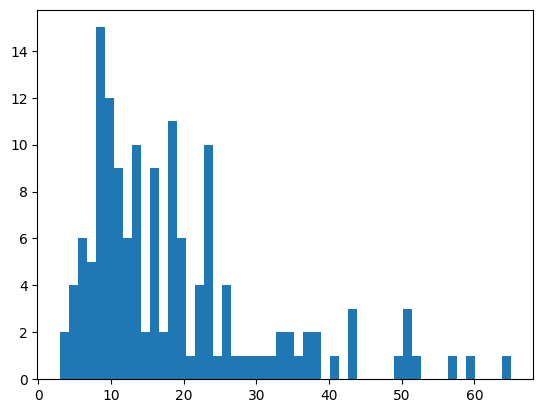

In [19]:
import matplotlib.pyplot as plt
plt.hist(seq_day.T,bins=50)

In [20]:
total

8202

In [21]:
print(len(seq_day),len(seq_night),len(fire_pred))

145 145 145


In [22]:
todos_iguales = np.all([seq_day == seq_night, seq_night == fire_pred], axis=0)
all(todos_iguales)

True

In [23]:
len(path_valid)

145

In [24]:
def analyze_shapes(data, paths=None):
    """
    Extrae dimensiones, número de bandas y rutas de todos los archivos TIFF.
    
    Retorna (para cada categoría):
        shapes_X, bands_X, paths_X
    donde:
        shapes_X[i], bands_X[i], paths_X[i] → corresponden al mismo archivo.
    """
    # Inicializar listas: shapes, bands, paths
    shapes_day, bands_day, paths_day = [], [], []
    shapes_night, bands_night, paths_night = [], [], []
    shapes_pred, bands_pred, paths_pred = [], [], []
    shapes_lulc, bands_lulc, paths_lulc = [], [], []

    if paths is None:
        dir_items = data["directories"].items()
    else:
        dir_items = []
        for p in paths:
            if p in data["directories"]:
                dir_items.append((p, data["directories"][p]))
            else:
                for name, info in data["directories"].items():
                    if info["path"] == p:
                        dir_items.append((name, info))
                        break

    for dir_name, dir_info in dir_items:
        folders = dir_info["folders"]
        
        # Mapeo: folder → (shapes_list, bands_list, paths_list)
        mapping = {
            "VIIRS_Day":   (shapes_day,   bands_day,   paths_day),
            "VIIRS_Night": (shapes_night, bands_night, paths_night),
            "FirePred":    (shapes_pred,  bands_pred,  paths_pred),
            "ESRI_LULC":   (shapes_lulc,  bands_lulc,  paths_lulc)
        }
        
        for folder_name, (shape_list, band_list, path_list) in mapping.items():
            folder_data = folders.get(folder_name, {})
            if not folder_data.get("exists", False):
                continue
                
            for file_info in folder_data.get("files", []):
                meta = file_info.get("metadata", {})
                dim = meta.get("Dimensiones")
                bands = meta.get("bandas")
                filepath = file_info.get("path")
                
                if dim is not None and bands is not None and filepath is not None:
                    shape_list.append(tuple(dim))  # (alto, ancho)
                    band_list.append(int(bands))
                    path_list.append(filepath)
                else:
                    print(f"⚠️ Datos incompletos en {folder_name} / {dir_name}")

    return (
        # VIIRS_Day
        shapes_day, bands_day, paths_day,
        # VIIRS_Night
        shapes_night, bands_night, paths_night,
        # FirePred
        shapes_pred, bands_pred, paths_pred,
        # ESRI_LULC
        shapes_lulc, bands_lulc, paths_lulc
    )

In [25]:
(
    shapes_day, bands_day, paths_day,
    shapes_night, bands_night, paths_night,
    shapes_pred, bands_pred, paths_pred,
    shapes_lulc, bands_lulc, paths_lulc
) = analyze_shapes(data,paths=path_valid)

In [26]:
from collections import Counter

def check_consistency(shapes, bands, name):
    if not shapes:
        print(f"⚠️ {name}: sin datos")
        return
    
    shape_counts = Counter(shapes)
    band_counts = Counter(bands)
    
    print(f"\n{name}: {len(shapes)} archivos")
    print(f"  Dimensiones: {dict(shape_counts)}")
    print(f"  Bandas:      {dict(band_counts)}")
    

check_consistency(shapes_day, bands_day, "VIIRS_Day")
check_consistency(shapes_pred, bands_pred, "FirePred")
check_consistency(shapes_night, bands_night, "VIIRS_Night")
check_consistency(shapes_lulc, bands_lulc, "ESRI_LULC")


VIIRS_Day: 2734 archivos
  Dimensiones: {(596, 594): 638, (596, 595): 1985, (595, 595): 98, (595, 594): 13}
  Bandas:      {8: 2734}

FirePred: 2734 archivos
  Dimensiones: {(596, 594): 472, (596, 595): 1469, (447, 446): 446, (448, 446): 54, (595, 595): 90, (447, 447): 125, (448, 447): 65, (595, 594): 13}
  Bandas:      {19: 2734}

VIIRS_Night: 2734 archivos
  Dimensiones: {(596, 594): 638, (596, 595): 1985, (595, 595): 98, (595, 594): 13}
  Bandas:      {2: 2724, 5: 10}

ESRI_LULC: 145 archivos
  Dimensiones: {(22313, 22265): 59, (22314, 22265): 21, (22312, 22265): 20, (22310, 22265): 8, (22311, 22265): 16, (22314, 22264): 5, (22303, 22264): 1, (22313, 22264): 8, (22312, 22264): 5, (22309, 22265): 2}
  Bandas:      {1: 145}


In [31]:
problematic = [
    (dim, bands, path)
    for dim, bands, path in zip(shapes_night, bands_night, paths_night)
    if bands != 2
]
nproblematic = [
    (dim, bands, path)
    for dim, bands, path in zip(shapes_night, bands_night, paths_night)
    if bands == 2
]
if problematic:
    print(f"VIIRS_Night con bandas = 5: {len(problematic)}")
    for _, b, p in problematic:
        print(f"  {b} bandas → {p}")

VIIRS_Night con bandas = 5: 10
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/21889953/VIIRS_Night/2018-07-20_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/23036806/VIIRS_Night/2019-07-18_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/22712973/VIIRS_Night/2019-03-22_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/21804884/VIIRS_Night/2018-06-29_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/21804884/VIIRS_Night/2018-06-24_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/21890502/VIIRS_Night/2018-07-19_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/21890502/VIIRS_Night/2018-07-25_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/21890502/VIIRS_Night/2018-07-20_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/21889992/VIIRS_Night/2018-07-20_VIIRS_Night.tif
  5 bandas → /kaggle/input/ts-satfire/ts-satfire/23410594/VIIRS_Night/2019-10-31_VIIRS_Night.tif

Procesando 10 archivos...


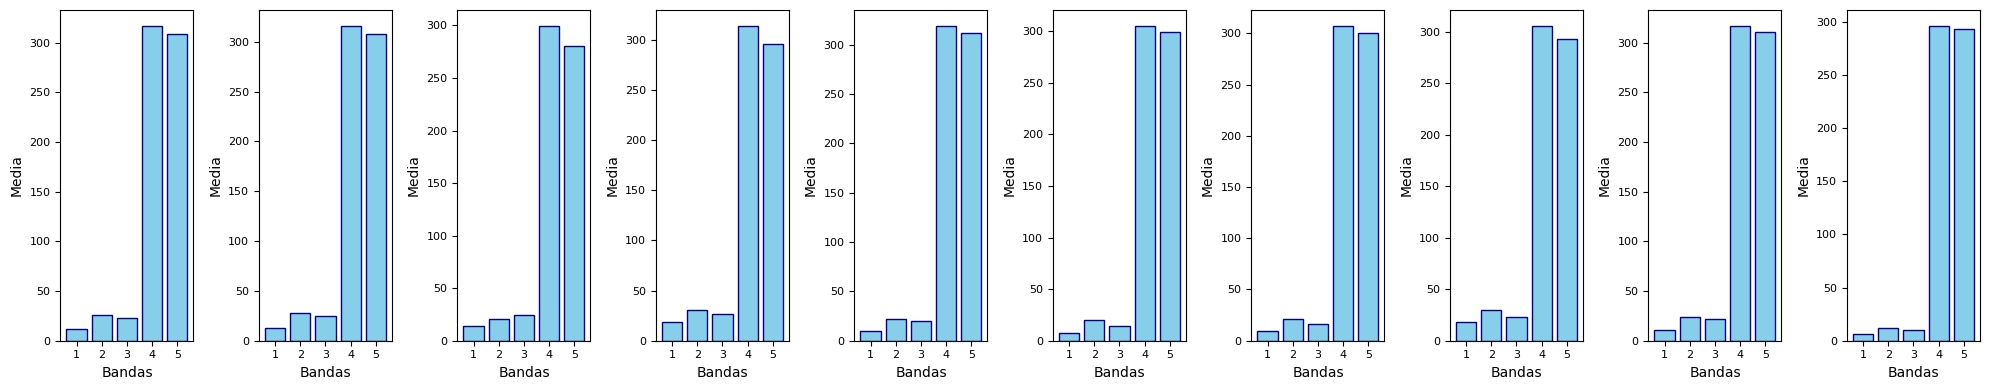

In [30]:
# import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os
from math import ceil

def plot_problematic_stats(problematic_list, num_bands=10, cols=5):
    # 1. Recolectar datos
    all_stats = []
    file_names = []
    
    print(f"Procesando {len(problematic_list)} archivos...")
    
    for item in problematic_list:
      
        path = item[2] 
        file_names.append(os.path.basename(path))
        
        try:
            with rasterio.open(path) as src:
                stats = []
                # Leer hasta num_bands o el máximo disponible
                limit = min(src.count, num_bands)
                for i in range(1, limit + 1):
                    band = src.read(i)
                    # Manejo de nodata
                    if src.nodata is not None:
                        valid = band[band != src.nodata]
                    else:
                        valid = band[~np.isnan(band)]
                    
                    stats.append(valid.mean() if valid.size > 0 else 0)
                
                # Rellenar con 0 si tiene menos de 10 bandas
                while len(stats) < num_bands:
                    stats.append(0)
                all_stats.append(stats)
        except Exception as e:
            print(f"Error en {path}: {e}")
            all_stats.append([0] * num_bands)

    # 2. Configurar el Grid de Gráficos
    num_files = len(all_stats)
    rows = ceil(num_files / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < num_files:
            # Graficar barras para las 10 bandas
            bars = axes[i].bar(range(1, num_bands + 1), all_stats[i], color='skyblue', edgecolor='navy')
            axes[i].set_xticks(range(1, num_bands + 1))
            axes[i].set_xlabel("Bandas")
            axes[i].set_ylabel("Media")
            
            # Ajustar escala para que sea legible
            axes[i].tick_params(axis='both', which='major', labelsize=8)
        else:
            # Ocultar subplots vacíos
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("problematic_files_bands_report.png", dpi=150)
    plt.show()


plot_problematic_stats(problematic, num_bands=5, cols=10)

In [41]:
import os
import rasterio
import numpy as np

def inspect_problematic_files(path):
    """
    Inspecciona un archivo raster y muestra toda su metadata y estadísticas.
    
    Args:
        path: Ruta al archivo raster
    """
    try:
        with rasterio.open(path) as src:
            print(f"\n  Dimensiones: {src.shape} (alto × ancho)")
            print(f"   Bandas: {src.count}")
            print(f"   CRS: {src.crs or 'No georreferenciado'}")
            print(f"   Resolución: {src.res} (grados o m/px)")
            print(f"   Tipo de dato: {src.dtypes[0]}")
            print(f"   Nodata: {src.nodata}")
            print(f"   Driver: {src.driver}")
            print(f"   Transform: {list(src.transform)}")
            print(f"   description: {src.descriptions}")
            
            # Leer y analizar cada banda
            for i in range(1, src.count + 1):
                try:
                    band = src.read(i)
                    
                    # Manejar valores nodata
                    if src.nodata is not None:
                        valid = band[band != src.nodata]
                    else:
                        valid = band[~np.isnan(band)]
                    
                    if valid.size > 0:
                        print(f"      Banda {i}: min={valid.min():.2f}, max={valid.max():.2f}, "
                              f"mean={valid.mean():.2f}, std={valid.std():.2f}")
                    else:
                        print(f"      Banda {i}: sin datos válidos")
                        
                except Exception as e:
                    print(f"      Banda {i}: error al leer → {e}")
    
    except Exception as e:
        print(f"   ❌ Error al abrir: {e}")
    
    print()

In [45]:
inspect_problematic_files('/kaggle/input/ts-satfire/ts-satfire/20777203/VIIRS_Night/2017-07-09_VIIRS_Night.tif')


  Dimensiones: (596, 595) (alto × ancho)
   Bandas: 2
   CRS: EPSG:4326
   Resolución: (0.0033686823154482058, 0.0033686823154482058) (grados o m/px)
   Tipo de dato: float32
   Nodata: None
   Driver: GTiff
   Transform: [0.0033686823154482058, 0.0, -121.2793007207663, 0.0, -0.0033686823154482058, 35.977527128986836, 0.0, 0.0, 1.0]
   description: ('b1', 'b2')
      Banda 1: min=250.83, max=357.48, mean=286.86, std=8.19
      Banda 2: min=252.69, max=343.45, mean=285.68, std=8.39



In [34]:
"""import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import rasterio
import glob
import os
import re
from datetime import datetime
from IPython.display import Image, display

def create_clean_fire_gif(region_path, 
                         product='VIIRS_Day', 
                         output_name='fire_evolution_clean.gif',
                         fps=0.5,         
                         fire_alpha=0.7):  
    

    product_path = os.path.join(region_path, product)
    files = sorted(glob.glob(os.path.join(product_path, "*.tif")))
    
    if not files:
        print(f"❌ No hay archivos en {product_path}")
        return
    

    def extract_date_from_filename(filepath):
        
        filename = os.path.basename(filepath)
        
        # Patrones para fechas en formato 2017-04-23_VIIRS_Day.tif
        patterns = [
            r'(\d{4})-(\d{2})-(\d{2})',  # 2017-04-23
            r'(\d{4})_(\d{2})_(\d{2})',  # 2017_04_23
            r'(\d{8})',                  # 20170423
        ]
        
        for pattern in patterns:
            match = re.search(pattern, filename)
            if match:
                if len(match.groups()) == 3:
                    year, month, day = match.groups()
                    return datetime(int(year), int(month), int(day))
                elif len(match.groups()) == 1:
                    
                    date_str = match.group(1)
                    if len(date_str) == 8:
                        year = int(date_str[:4])
                        month = int(date_str[4:6])
                        day = int(date_str[6:8])
                        return datetime(year, month, day)
        
        print(f"⚠️  No se pudo extraer fecha de: {filename}")
        return datetime(1900, 1, 1)
    
    dated_files = []
    for filepath in files:
        date_obj = extract_date_from_filename(filepath)
        dated_files.append((date_obj, filepath))
    
    dated_files.sort(key=lambda x: x[0])
  

    frames_data = []
    
    for date_obj, filepath in dated_files:
        try:
            with rasterio.open(filepath) as src:
   
                band_map = {desc: i+1 for i, desc in enumerate(src.descriptions) if desc}
                
                if 'af' not in band_map or not all(b in band_map for b in ['b1','b2','b3']):
                    print(f" Saltando {os.path.basename(filepath)}: faltan bandas")
                    continue
                
                # Leer datos de fuego
                fire_data = src.read(band_map['af'])
                fire_mask = fire_data > 0
                
                fire_count = np.sum(fire_mask)
                h, w = fire_data.shape
                
                # Leer bandas RGB
                r = src.read(band_map['b3'])[:h, :w].astype(float)
                g = src.read(band_map['b2'])[:h, :w].astype(float)
                b = src.read(band_map['b1'])[:h, :w].astype(float)
                

                def safe_norm(x):
                    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
                    x = x.clip(np.percentile(x, 2), np.percentile(x, 98))
                    if x.max() == x.min():
                        return np.zeros_like(x)
                    return (x - x.min()) / (x.max() - x.min())
                
                rgb = np.dstack([safe_norm(r), safe_norm(g), safe_norm(b)])
                rgb = np.clip(rgb ** 0.6, 0, 1)  
                
         
                overlay = np.zeros((h, w, 4))
                overlay[fire_mask] = [1.0, 0.0, 0.0, fire_alpha] 
                
         
                date_str = date_obj.strftime("%d/%m/%Y")
                
                frames_data.append({
                    'rgb': rgb,
                    'overlay': overlay,
                    'date': date_str,
                    'count': int(fire_count),
                    'datetime': date_obj  # Guardar para referencia
                })
                
                print(f"  {date_str}: {fire_count:,} píxeles de fuego")
                
        except Exception as e:
            print(f"Error en {os.path.basename(filepath)}: {e}")
            continue

    if len(frames_data) < 2:
        print("Se necesitan al menos 2 imágenes válidas")
        return
    
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='black')
    ax.set_facecolor('black')
    ax.axis('off')

    img_rgb = ax.imshow(frames_data[0]['rgb'])
    img_fire = ax.imshow(frames_data[0]['overlay'])
    

    title = ax.text(
        0.02, 0.98, '', transform=ax.transAxes,
        color='white', fontsize=16, fontweight='bold',
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.7, edgecolor='red')
    )
    
    def update(frame_idx):
        frame = frames_data[frame_idx]
        img_rgb.set_array(frame['rgb'])
        img_fire.set_array(frame['overlay'])
        title.set_text(f"INCENDIO ACTIVO\n{frame['date']}\nPíxeles: {frame['count']:,}")
        return img_rgb, img_fire, title

    anim = FuncAnimation(
        fig, update, frames=len(frames_data),
        interval=1000/fps, 
        blit=True, repeat=True
    )
    
    print(f"\nGuardando {output_name}...")
    anim.save(output_name, writer=PillowWriter(fps=fps), dpi=120)
    plt.close(fig)
    
    print("¡GIF creado!")
    try:
        display(Image(filename=output_name))
    except:
        print(f" Guardado: {output_name}")
    
    return frames_data  


region_path = '/kaggle/input/ts-satfire/ts-satfire/20701026'
frames = create_clean_fire_gif(
    region_path=region_path,
    product='VIIRS_Day',
    output_name='fire_evolution_ordered.gif',
    fps=0.5,          
    fire_alpha=0.9  
)
"""

<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_55/3028245156.py:32: SyntaxWarning: invalid escape sequence '\d'
  r'(\d{4})-(\d{2})-(\d{2})',  # 2017-04-23


'import numpy as np\nimport matplotlib.pyplot as plt\nfrom matplotlib.animation import FuncAnimation, PillowWriter\nimport rasterio\nimport glob\nimport os\nimport re\nfrom datetime import datetime\nfrom IPython.display import Image, display\n\ndef create_clean_fire_gif(region_path, \n                         product=\'VIIRS_Day\', \n                         output_name=\'fire_evolution_clean.gif\',\n                         fps=0.5,         \n                         fire_alpha=0.7):  \n    \n\n    product_path = os.path.join(region_path, product)\n    files = sorted(glob.glob(os.path.join(product_path, "*.tif")))\n    \n    if not files:\n        print(f"❌ No hay archivos en {product_path}")\n        return\n    \n\n    def extract_date_from_filename(filepath):\n        \n        filename = os.path.basename(filepath)\n        \n        # Patrones para fechas en formato 2017-04-23_VIIRS_Day.tif\n        patterns = [\n            r\'(\\d{4})-(\\d{2})-(\\d{2})\',  # 2017-04-23\n        

In [35]:
"""import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import rasterio
import glob
import os
import re
from datetime import datetime
from IPython.display import Image, display
from rasterio.warp import reproject, Resampling

def reproject_image(img, src_transform, src_crs, target_shape, resampling=Resampling.nearest):
   
    # Asegurarnos de que img tenga 3 dimensiones
    if img.ndim == 2:
        img = img[np.newaxis, :, :]
    
    H, W = img.shape[-2], img.shape[-1]
    H_new, W_new = target_shape
    
    scale_x = W / W_new
    scale_y = H / H_new
    new_transform = src_transform * src_transform.scale(scale_x, scale_y)
    
    # Allocate output
    dst_shape = (img.shape[0], H_new, W_new)
    dst_img = np.empty(dst_shape, dtype=img.dtype)
    
    reproject(
        source=img,
        destination=dst_img,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=new_transform,
        dst_crs=src_crs,  # keep same CRS
        resampling=resampling
    )
    
    # Si la entrada era 2D, devolver 2D
    if img.shape[0] == 1:
        dst_img = dst_img[0]
    
    return dst_img, new_transform

def create_clean_fire_gif(region_path, 
                         product='VIIRS_Day', 
                         output_name='fire_evolution_clean.gif',
                         target_size=(400, 400),
                         fps=0.5,         
                         fire_alpha=0.7):  

    
    product_path = os.path.join(region_path, product)
    files = sorted(glob.glob(os.path.join(product_path, "*.tif")))
    
    if not files:
        print(f"❌ No hay archivos en {product_path}")
        return
    
    def extract_date_from_filename(filepath):
        
        filename = os.path.basename(filepath)
        
        patterns = [
            r'(\d{4})-(\d{2})-(\d{2})',
            r'(\d{4})_(\d{2})_(\d{2})',
            r'(\d{8})',
        ]
        
        for pattern in patterns:
            match = re.search(pattern, filename)
            if match:
                if len(match.groups()) == 3:
                    year, month, day = match.groups()
                    return datetime(int(year), int(month), int(day))
                elif len(match.groups()) == 1:
                    date_str = match.group(1)
                    if len(date_str) == 8:
                        year = int(date_str[:4])
                        month = int(date_str[4:6])
                        day = int(date_str[6:8])
                        return datetime(year, month, day)
        
        print(f"⚠️  No se pudo extraer fecha de: {filename}")
        return datetime(1900, 1, 1)
    
    # Ordenar por fecha
    dated_files = []
    for filepath in files:
        date_obj = extract_date_from_filename(filepath)
        dated_files.append((date_obj, filepath))
    
    dated_files.sort(key=lambda x: x[0])
    
    frames_data = []
    
    for idx, (date_obj, filepath) in enumerate(dated_files):
        try:
            with rasterio.open(filepath) as src:
                # Crear mapa de bandas
                band_map = {}
                if src.descriptions:
                    for i, desc in enumerate(src.descriptions):
                        if desc and desc.strip():
                            band_map[desc.strip().lower()] = i + 1
                
                # Verificar bandas requeridas
                required_bands = ['af', 'b1', 'b2', 'b3']
                missing_bands = [b for b in required_bands if b not in band_map]
                if missing_bands:
                    print(f" Saltando {os.path.basename(filepath)}: faltan bandas {missing_bands}")
                    continue
                
                print(f"\n[{idx+1}/{len(dated_files)}] Procesando {os.path.basename(filepath)}:")
                print(f"  Tamaño original: {src.height}x{src.width}")
                print(f"  Tamaño objetivo: {target_size}")
                
                # Leer y reproyectar cada banda usando tu función
                print("  Reprojectando bandas...")
                
                # Fuego (banda af)
                fire_orig = src.read(band_map['af'])
                fire_resized, _ = reproject_image(
                    fire_orig, 
                    src.transform, 
                    src.crs, 
                    target_size,
                    Resampling.nearest
                )
                
                # Bandas RGB
                r_orig = src.read(band_map['b3'])
                g_orig = src.read(band_map['b2'])
                b_orig = src.read(band_map['b1'])
                
                r_resized, _ = reproject_image(
                    r_orig, 
                    src.transform, 
                    src.crs, 
                    target_size,
                    Resampling.bilinear
                )
                
                g_resized, _ = reproject_image(
                    g_orig, 
                    src.transform, 
                    src.crs, 
                    target_size,
                    Resampling.bilinear
                )
                
                b_resized, _ = reproject_image(
                    b_orig, 
                    src.transform, 
                    src.crs, 
                    target_size,
                    Resampling.bilinear
                )
                
                # Crear máscara de fuego
                fire_mask = fire_resized > 0
                fire_count = np.sum(fire_mask)
                
                # Normalización mejorada para imágenes satelitales
                def enhance_satellite_band(band):
                    
                    band = np.nan_to_num(band, nan=0.0, posinf=0.0, neginf=0.0)
                    
                    # Usar valores válidos (no cero) para el estiramiento de histograma
                    valid_values = band[band > 0]
                    if len(valid_values) == 0:
                        return np.zeros_like(band)
                    
                    # Percentiles para evitar outliers
                    p2 = np.percentile(valid_values, 2)
                    p98 = np.percentile(valid_values, 98)
                    
                    # Aplicar estiramiento lineal
                    band_clipped = np.clip(band, p2, p98)
                    band_normalized = (band_clipped - p2) / (p98 - p2 + 1e-10)
                    
                    return np.clip(band_normalized, 0, 1)
                
                # Aplicar mejora a cada banda
                print("  Mejorando contraste de bandas...")
                r_enhanced = enhance_satellite_band(r_resized.astype(float))
                g_enhanced = enhance_satellite_band(g_resized.astype(float))
                b_enhanced = enhance_satellite_band(b_resized.astype(float))
                
                # Combinar en imagen RGB
                rgb = np.dstack([r_enhanced, g_enhanced, b_enhanced])
                
                # Ajuste gamma para mejor visualización
                gamma = 0.6
                rgb = np.clip(rgb ** gamma, 0, 1)
                
                # Crear overlay de fuego con diferentes intensidades
                overlay = np.zeros((target_size[0], target_size[1], 4))
                
                if fire_count > 0:
                    # Usar valores de fuego para crear gradiente de intensidad
                    fire_normalized = fire_resized / (fire_resized.max() + 1e-10)
                    
                    # Colores más vibrantes para el fuego
                    for i in range(target_size[0]):
                        for j in range(target_size[1]):
                            if fire_mask[i, j]:
                                intensity = fire_normalized[i, j]
                                # Rojo anaranjado brillante con variación
                                overlay[i, j] = [
                                    1.0,                    # R
                                    0.3 * (1 - intensity),  # G (menos para fuego más intenso)
                                    0.1,                    # B
                                    fire_alpha * (0.7 + 0.3 * intensity)  # Alpha variable
                                ]
                
                date_str = date_obj.strftime("%d/%m/%Y")
                
                # Guardar frame
                frames_data.append({
                    'rgb': rgb,
                    'overlay': overlay,
                    'date': date_str,
                    'count': int(fire_count),
                    'datetime': date_obj,
                    'shape': rgb.shape,
                    'filename': os.path.basename(filepath)
                })
                
                print(f"  ✓ {date_str}: {fire_count:,} píxeles de fuego")
                
        except Exception as e:
            print(f"  ✗ Error: {e}")
            continue
    
    if len(frames_data) < 2:
        print(f"\n❌ Se necesitan al menos 2 imágenes válidas (encontradas: {len(frames_data)})")
        return
    
    print(f"\n✅ {len(frames_data)} frames procesados exitosamente")
    print(f"📏 Tamaño de imagen final: {target_size}")
    
    # Crear animación
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='black')
    ax.set_facecolor('black')
    ax.axis('off')
    ax.set_aspect('equal')
    
    # Mostrar primer frame
    img_rgb = ax.imshow(frames_data[0]['rgb'])
    img_fire = ax.imshow(frames_data[0]['overlay'])
    
    # Título informativo
    title = ax.text(
        0.02, 0.98, '', transform=ax.transAxes,
        color='white', fontsize=18, fontweight='bold',
        verticalalignment='top',
        bbox=dict(
            boxstyle='round,pad=0.8', 
            facecolor='black', 
            alpha=0.8, 
            edgecolor='red', 
            linewidth=2
        )
    )
    
    def update(frame_idx):
        frame = frames_data[frame_idx]
        img_rgb.set_array(frame['rgb'])
        img_fire.set_array(frame['overlay'])
        title.set_text(f"🔥 INCENDIO ACTIVO 🔥\nFecha: {frame['date']}\nPíxeles de fuego: {frame['count']:,}")
        return img_rgb, img_fire, title
    
    # Crear animación
    anim = FuncAnimation(
        fig, 
        update, 
        frames=len(frames_data),
        interval=1000/fps,  # 2 segundos por frame con fps=0.5
        blit=True, 
        repeat=True
    )
    
    # Guardar GIF
    print(f"\n💾 Guardando {output_name}...")
    anim.save(
        output_name, 
        writer=PillowWriter(fps=fps), 
        dpi=150,
        savefig_kwargs={'facecolor': 'black'}
    )
    plt.close(fig)
    
    print(f"✅ GIF creado exitosamente!")
    
    # Mostrar información del GIF
    print(f"\n📊 Resumen del GIF:")
    print(f"   - Frames: {len(frames_data)}")
    print(f"   - Tamaño: {target_size[1]}x{target_size[0]} píxeles")
    print(f"   - Duración: {len(frames_data)/fps:.1f} segundos")
    print(f"   - FPS: {fps}")
    print(f"   - Tiempo por frame: {1/fps:.1f} segundos")
    
    # Intentar mostrar el GIF
    try:
        display(Image(filename=output_name))
    except Exception as e:
        print(f"\n📁 GIF guardado como: {output_name}")
        print(f"ℹ️  No se pudo mostrar preview: {e}")
    
    return frames_data



def create_fire_gif_preserve_aspect(region_path, 
                                   product='VIIRS_Day', 
                                   output_name='fire_evolution_preserve.gif',
                                   max_dimension=500,
                                   fps=0.5,
                                   fire_alpha=0.8):
    
    
    product_path = os.path.join(region_path, product)
    files = sorted(glob.glob(os.path.join(product_path, "*.tif")))
    
    if not files:
        print(f"❌ No hay archivos en {product_path}")
        return
        
    # Leer primer archivo para determinar relación de aspecto
    try:
        with rasterio.open(files[0]) as sample_src:
            orig_height = sample_src.height
            orig_width = sample_src.width
            aspect_ratio = orig_width / orig_height
            
            # Calcular tamaño manteniendo relación de aspecto
            if orig_width > orig_height:
                target_width = max_dimension
                target_height = int(max_dimension / aspect_ratio)
            else:
                target_height = max_dimension
                target_width = int(max_dimension * aspect_ratio)
            
            target_size = (target_height, target_width)
            
            print(f"📐 Relación de aspecto original: {orig_width}x{orig_height} ({aspect_ratio:.3f})")
            print(f"📏 Tamaño objetivo: {target_width}x{target_height}")
    except:
        # Si falla, usar tamaño cuadrado por defecto
        target_size = (max_dimension, max_dimension)
        print(f"⚠️  Usando tamaño por defecto: {max_dimension}x{max_dimension}")
    
    # Llamar a la función principal con el tamaño calculado
    return create_clean_fire_gif(
        region_path=region_path,
        product=product,
        output_name=output_name,
        target_size=target_size,
        fps=fps,
        fire_alpha=fire_alpha
    )


if __name__ == "__main__":
    region_path = '/kaggle/input/ts-satfire/ts-satfire/20701026'
    
    frames = create_fire_gif_preserve_aspect(
         region_path=region_path,
         product='VIIRS_Day',
         output_name='fire_evolution_preserve_aspect.gif',
         max_dimension=256,
         fps=0.5,
         fire_alpha=0.9
     )"""

<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_55/1135009855.py:65: SyntaxWarning: invalid escape sequence '\d'
  r'(\d{4})-(\d{2})-(\d{2})',


'import numpy as np\nimport matplotlib.pyplot as plt\nfrom matplotlib.animation import FuncAnimation, PillowWriter\nimport rasterio\nimport glob\nimport os\nimport re\nfrom datetime import datetime\nfrom IPython.display import Image, display\nfrom rasterio.warp import reproject, Resampling\n\ndef reproject_image(img, src_transform, src_crs, target_shape, resampling=Resampling.nearest):\n   \n    # Asegurarnos de que img tenga 3 dimensiones\n    if img.ndim == 2:\n        img = img[np.newaxis, :, :]\n    \n    H, W = img.shape[-2], img.shape[-1]\n    H_new, W_new = target_shape\n    \n    scale_x = W / W_new\n    scale_y = H / H_new\n    new_transform = src_transform * src_transform.scale(scale_x, scale_y)\n    \n    # Allocate output\n    dst_shape = (img.shape[0], H_new, W_new)\n    dst_img = np.empty(dst_shape, dtype=img.dtype)\n    \n    reproject(\n        source=img,\n        destination=dst_img,\n        src_transform=src_transform,\n        src_crs=src_crs,\n        dst_transfor

In [36]:
"""import rasterio
import numpy as np

# Ruta al archivo
filepath = "/kaggle/input/ts-satfire/ts-satfire/20701026/VIIRS_Day/2017-06-08_VIIRS_Day.tif"

with rasterio.open(filepath) as src:
    n_bands = src.count
    if n_bands == 0:
        raise ValueError("El archivo no contiene bandas.")
    
    # Leer la última banda
    last_band = src.read(n_bands)
    
    # Obtener el valor de 'nodata' (si existe)
    nodata = src.nodata
    
    data = last_band.astype('float32')
    
    if nodata is not None:
        data[data == nodata] = np.nan

    valid_data = data[np.isfinite(data)]
    
    if valid_data.size == 0:
        print("⚠️ No hay datos válidos en la banda.")
    else:
        print(f"Estadísticas de la última banda (banda {n_bands}):")
        print(f"   - Nombre: {src.descriptions[n_bands - 1] or 'Sin nombre'}")
        print(f"   - Tamaño: {data.shape[0]} x {data.shape[1]} píxeles")
        print(f"   - Total de píxeles: {data.size:,}")
        print(f"   - Píxeles válidos: {valid_data.size:,}")
        print(f"   - Valores únicos (muestra): {np.unique(valid_data)[:10]}{'...' if len(np.unique(valid_data)) > 10 else ''}")
        print(f"   - Mínimo: {valid_data.min():.4f}")
        print(f"   - Máximo: {valid_data.max():.4f}")
        print(f"   - Media: {valid_data.mean():.4f}")
        print(f"   - Desviación estándar: {valid_data.std():.4f}")
        print(f"   - Mediana: {np.median(valid_data):.4f}")
        print(f"   - Valor nodata definido: {nodata}")"""

'import rasterio\nimport numpy as np\n\n# Ruta al archivo\nfilepath = "/kaggle/input/ts-satfire/ts-satfire/20701026/VIIRS_Day/2017-06-08_VIIRS_Day.tif"\n\nwith rasterio.open(filepath) as src:\n    n_bands = src.count\n    if n_bands == 0:\n        raise ValueError("El archivo no contiene bandas.")\n    \n    # Leer la última banda\n    last_band = src.read(n_bands)\n    \n    # Obtener el valor de \'nodata\' (si existe)\n    nodata = src.nodata\n    \n    data = last_band.astype(\'float32\')\n    \n    if nodata is not None:\n        data[data == nodata] = np.nan\n\n    valid_data = data[np.isfinite(data)]\n    \n    if valid_data.size == 0:\n        print("⚠️ No hay datos válidos en la banda.")\n    else:\n        print(f"Estadísticas de la última banda (banda {n_bands}):")\n        print(f"   - Nombre: {src.descriptions[n_bands - 1] or \'Sin nombre\'}")\n        print(f"   - Tamaño: {data.shape[0]} x {data.shape[1]} píxeles")\n        print(f"   - Total de píxeles: {data.size:,}")\n 

In [24]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 57.1 MB/s eta 0:00:00:00:0100:01


In [38]:
"""from rasterio.transform import xy


import rasterio

with rasterio.open(filepath) as src:
    if src.crs != "EPSG:4326":
        raise ValueError("Este cálculo solo es válido para EPSG:4326 (lat/lon)")
    transform = src.transform
    height = src.height
    width = src.width
    
    # Coordenadas de las 4 esquinas
    ul = xy(transform,rows=0, cols=0)           # upper-left
    ur = xy(transform,rows=0, cols=width - 1)   # upper-right
    ll = xy(transform,rows=height - 1, cols=0)  # lower-left
    lr = xy(transform,rows=height - 1, cols=width - 1)  # lower-right
    
    # Latitudes (Y) de las esquinas
    lats = [ul[1], ur[1], ll[1], lr[1]]
    
    # Latitud central = promedio de la esquina superior e inferior
    lat_central = (min(lats) + max(lats)) / 2
    
    print(f"Latitud mínima: {min(lats):.6f}°")
    print(f"Latitud máxima: {max(lats):.6f}°")
    print(f"➡️ Latitud central para cálculos: {lat_central:.6f}°")"""

'from rasterio.transform import xy\n\n\nimport rasterio\n\nwith rasterio.open(filepath) as src:\n    if src.crs != "EPSG:4326":\n        raise ValueError("Este cálculo solo es válido para EPSG:4326 (lat/lon)")\n    transform = src.transform\n    height = src.height\n    width = src.width\n    \n    # Coordenadas de las 4 esquinas\n    ul = xy(transform,rows=0, cols=0)           # upper-left\n    ur = xy(transform,rows=0, cols=width - 1)   # upper-right\n    ll = xy(transform,rows=height - 1, cols=0)  # lower-left\n    lr = xy(transform,rows=height - 1, cols=width - 1)  # lower-right\n    \n    # Latitudes (Y) de las esquinas\n    lats = [ul[1], ur[1], ll[1], lr[1]]\n    \n    # Latitud central = promedio de la esquina superior e inferior\n    lat_central = (min(lats) + max(lats)) / 2\n    \n    print(f"Latitud mínima: {min(lats):.6f}°")\n    print(f"Latitud máxima: {max(lats):.6f}°")\n    print(f"➡️ Latitud central para cálculos: {lat_central:.6f}°")'

In [39]:
"""import rasterio
import math

with rasterio.open(filepath) as src:
    print("Resolución (ancho, alto):", src.res)
    print("Ancho del píxel (Δx):", src.res[0], "grados")
    print("Alto del píxel (Δy):", src.res[1], "grados")
    

    # Tu resolución en grados
    res_deg = src.res[0]
    
    # Latitud de referencia
    lat = 31.808783  # en grados
    
    # Metros por grado
    meters_per_deg_lat = 111320  # ~111.32 km
    meters_per_deg_lon = 111320 * math.cos(math.radians(lat))
    
    # Tamaño de UN píxel en metros
    pixel_width_m  = res_deg * meters_per_deg_lon   # este-oeste
    pixel_height_m = res_deg * meters_per_deg_lat   # norte-sur
    
    print(f"Tamaño de 1 píxel:")
    print(f"  → Ancho: {pixel_width_m:.1f} metros")
    print(f"  → Alto:  {pixel_height_m:.1f} metros")
    print(f"  → Área:  {pixel_width_m * pixel_height_m:.0f} m² ≈ {(pixel_width_m * pixel_height_m)/1e6:.2f} km²")"""

'import rasterio\nimport math\n\nwith rasterio.open(filepath) as src:\n    print("Resolución (ancho, alto):", src.res)\n    print("Ancho del píxel (Δx):", src.res[0], "grados")\n    print("Alto del píxel (Δy):", src.res[1], "grados")\n    \n\n    # Tu resolución en grados\n    res_deg = src.res[0]\n    \n    # Latitud de referencia\n    lat = 31.808783  # en grados\n    \n    # Metros por grado\n    meters_per_deg_lat = 111320  # ~111.32 km\n    meters_per_deg_lon = 111320 * math.cos(math.radians(lat))\n    \n    # Tamaño de UN píxel en metros\n    pixel_width_m  = res_deg * meters_per_deg_lon   # este-oeste\n    pixel_height_m = res_deg * meters_per_deg_lat   # norte-sur\n    \n    print(f"Tamaño de 1 píxel:")\n    print(f"  → Ancho: {pixel_width_m:.1f} metros")\n    print(f"  → Alto:  {pixel_height_m:.1f} metros")\n    print(f"  → Área:  {pixel_width_m * pixel_height_m:.0f} m² ≈ {(pixel_width_m * pixel_height_m)/1e6:.2f} km²")'

In [40]:
"""import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Ruta al archivo nocturno \
night_path = "/kaggle/input/ts-satfire/ts-satfire/20701026/VIIRS_Night/2017-06-08_VIIRS_Night.tif"

# Abrir y leer ambas bandas
with rasterio.open(night_path) as src:
    i5 = src.read(1).astype(float)  # Banda I5 (11.45 µm) → superficie térmica
    i4 = src.read(2).astype(float)  # Banda I4 (3.74 µm) → sensible a fuego

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

im1 = ax1.imshow(i5, cmap='gray_r')  # Más frío = blanco, más caliente = negro
ax1.set_title('VIIRS Noche – Banda I5 (11.45 µm)\nTemperatura de superficie (K)', fontsize=13, fontweight='bold')
ax1.axis('off')
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, pad=0.02)
cbar1.set_label('Temperatura (K)', fontsize=11)

im2 = ax2.imshow(i4, cmap='hot')  # Fuego = amarillo/blanco brillante
ax2.set_title('VIIRS Noche – Banda I4 (3.74 µm)\nSensible a fuego activo (K)', fontsize=13, fontweight='bold')
ax2.axis('off')
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, pad=0.02)
cbar2.set_label('Temperatura (K)', fontsize=11)

plt.tight_layout()
plt.show()"""

'import rasterio\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Ruta al archivo nocturno night_path = "/kaggle/input/ts-satfire/ts-satfire/20701026/VIIRS_Night/2017-06-08_VIIRS_Night.tif"\n\n# Abrir y leer ambas bandas\nwith rasterio.open(night_path) as src:\n    i5 = src.read(1).astype(float)  # Banda I5 (11.45 µm) → superficie térmica\n    i4 = src.read(2).astype(float)  # Banda I4 (3.74 µm) → sensible a fuego\n\n# Crear figura con dos subplots\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))\n\nim1 = ax1.imshow(i5, cmap=\'gray_r\')  # Más frío = blanco, más caliente = negro\nax1.set_title(\'VIIRS Noche – Banda I5 (11.45 µm)\nTemperatura de superficie (K)\', fontsize=13, fontweight=\'bold\')\nax1.axis(\'off\')\ncbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, pad=0.02)\ncbar1.set_label(\'Temperatura (K)\', fontsize=11)\n\nim2 = ax2.imshow(i4, cmap=\'hot\')  # Fuego = amarillo/blanco brillante\nax2.set_title(\'VIIRS Noche – Banda I4 (3.74 µm)\nSensible a fuego activo (K)

In [41]:
!pip install rasterio

In [42]:
"""day_path = '/kaggle/input/ts-satfire/ts-satfire/20562846/VIIRS_Day/2017-04-27_VIIRS_Day.tif'

with rasterio.open(day_path) as src:
    af = np.nan_to_num(src.read(7))
    af_binary = (af > 0).astype(np.float32)
    
    # Opción 2: más robusta — ignorar NaNs y usar umbral automático
    # (evita falsos positivos por ruido numérico ~1e-6)
    af_binary = np.zeros_like(af)
    # Umbral: cualquier cosa > 1e-5 (para evitar ruido de float)
    af_binary[af > 1e-5] = 1.0
    nan_ratio = np.isnan(af).mean() * 100
    print(nan_ratio)
    print(src.descriptions)
    print(af_binary.max())"""

"day_path = '/kaggle/input/ts-satfire/ts-satfire/20562846/VIIRS_Day/2017-04-27_VIIRS_Day.tif'\n\nwith rasterio.open(day_path) as src:\n    af = np.nan_to_num(src.read(7))\n    af_binary = (af > 0).astype(np.float32)\n    \n    # Opción 2: más robusta — ignorar NaNs y usar umbral automático\n    # (evita falsos positivos por ruido numérico ~1e-6)\n    af_binary = np.zeros_like(af)\n    # Umbral: cualquier cosa > 1e-5 (para evitar ruido de float)\n    af_binary[af > 1e-5] = 1.0\n    nan_ratio = np.isnan(af).mean() * 100\n    print(nan_ratio)\n    print(src.descriptions)\n    print(af_binary.max())"

In [46]:
import random
from sklearn.model_selection import train_test_split
import os
import json
random.seed(42)

def split_data_deterministic(data, train_ratio=0.8, val_ratio=0.10, test_ratio=0.10):
    """
    División determinista de datos usando semilla global
    """
    shuffled_data = data.copy()
    random.shuffle(shuffled_data)
    
    total = len(shuffled_data)
    train_size = int(total * train_ratio)
    val_size = int(total * val_ratio)
    
    train_data = shuffled_data[:train_size]
    val_data = shuffled_data[train_size:train_size + val_size]
    test_data = shuffled_data[train_size + val_size:]
    
    return train_data, val_data, test_data

if not os.path.exists('files.json'):
    train, val, test = split_data_deterministic(list(path_valid))
    r ={}
    r['train']=train
    r['test']=test
    r['val']=val
    with open('files.json','w') as f:
              json.dump(r, f, ensure_ascii=False, indent=4)
else:
    with open('files.json','r') as f:
        data = json.load(f)
    train,val,test = data['train'],data['val'],data['test']

In [47]:


IMG_SHAPE = (512, 512)  
TILE_SIZE = 256         
OVERLAP = 48
INPUT_CHANNELS = 28 


DROPOUT = 0.1

# Training Hyperparameters
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 50
PRED_SEQ_LEN = 1 
ACCUM_STEPS = 1   
MAX_INPUT_SEQ_LEN = 3  

# Classification Thresholds
FIRE_THRESHOLDS = [0.5] 
NUM_CLASSES = len(FIRE_THRESHOLDS) + 1


CLASS_WEIGHTS = None 

In [48]:
import os
import json
import torch
import numpy as np
import rasterio
from torch.utils.data import Dataset
from pathlib import Path
from tqdm import tqdm

class TSDatasetFlat(Dataset):
    def __init__(
        self,
        path_valid,
        cache_dir,
        crop_size=256,
        seq_len=3,
        stride_t=1,
        force_rebuild=False,
    ):
        self.crop_size = crop_size
        self.seq_len = seq_len
        self.stride_t = stride_t
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

        self.catalog_path = self.cache_dir / f"catalog_flat_s{seq_len}_st{stride_t}_c{crop_size}.json"
        
        self.raw_paths = self._find_tiff_files(path_valid)

        if self.catalog_path.exists() and not force_rebuild:
            print(f"Cargando catálogo plano desde {self.catalog_path}...")
            with open(self.catalog_path, "r") as f:
                self.samples = json.load(f)
        else:
            print("Generando catálogo ...")
            self.samples = self._create_flat_catalog()
            with open(self.catalog_path, "w") as f:
                json.dump(self.samples, f)

        print(f"Dataset listo: {len(self.samples)} muestras independientes.")

    def _find_tiff_files(self, paths):
        r = {}
        for idx, base in enumerate(paths):
            r[idx] = {k: [] for k in ["FirePred", "VIIRS_Day", "VIIRS_Night"]}
            for folder in os.listdir(base):
                p = Path(base, folder)
                if p.is_dir() and folder in r[idx]:
                    r[idx][folder] = sorted(list(p.rglob("*.tif")), key=lambda x: x.name)
        return r

    def _create_flat_catalog(self):
        catalog = []
        for region_idx, folders in tqdm(self.raw_paths.items()):
            num_days = min(
                len(folders["VIIRS_Day"]),
                len(folders["VIIRS_Night"]),
                len(folders["FirePred"]),
            )
            
         
            for t_start in range(0, num_days - self.seq_len, self.stride_t):
                sample_id = f"reg{region_idx}_t{t_start}"
                catalog.append({
                    "region": region_idx,
                    "t_start": t_start,
                    "sample_id": sample_id
                })
        return catalog

    def _normalize(self, x, is_label=False):
        x = np.nan_to_num(x, nan=0.0)
        if is_label:
            return np.clip(x, 0.0, 1.0)
        for c in range(x.shape[0]):
            vmin, vmax = x[c].min(), x[c].max()
            if vmax - vmin > 1e-6:
                x[c] = (x[c] - vmin) / (vmax - vmin)
        return x

    def _load_single_window(self, info):
        region = self.raw_paths[info["region"]]
        t_start = info["t_start"]
        
        seq_x = []

        for t in range(t_start, t_start + self.seq_len):
            #  VIIRS Day
            with rasterio.open(region["VIIRS_Day"][t]) as dsrc:
                y0 = (dsrc.height - self.crop_size) // 2
                x0 = (dsrc.width - self.crop_size) // 2
                win = rasterio.windows.Window(x0, y0, self.crop_size, self.crop_size)
                day = self._normalize(dsrc.read([1,2,3,4,5,6], window=win))
                fire_today = self._normalize(dsrc.read([7], window=win), is_label=True)

            #  VIIRS Night
            with rasterio.open(region["VIIRS_Night"][t]) as nsrc:
                night = self._normalize(nsrc.read( window=win)[-2:])

            #  FirePred
            with rasterio.open(region["FirePred"][t]) as fsrc:
                firep = self._normalize(fsrc.read(window=win))

            x_combined = np.concatenate([day, fire_today, night, firep], axis=0)
            seq_x.append(x_combined)

        # Target
        with rasterio.open(region["VIIRS_Day"][t_start + self.seq_len]) as dsrc:
            y_target = self._normalize(dsrc.read([7], window=win), is_label=True)

        return np.stack(seq_x), y_target

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        info = self.samples[idx]
        cache_f = self.cache_dir / f"{info['sample_id']}.npz"

        if not cache_f.exists():
            x, y = self._load_single_window(info)
            np.savez_compressed(cache_f, x=x, y=y)
        else:
            try:
                data = np.load(cache_f)
                x, y = data["x"], data["y"]
            except Exception as e:
                print(f"Archivo corrupto detectado: {cache_f}")  
                return {}
        return {
            "x": torch.from_numpy(x).float(), # [T, C, H, W]
            "y": torch.from_numpy(y).float(), # [1, H, W] (Día siguiente)
            "id": info['sample_id']
        }


class TSDatasetFlatTF(TSDatasetFlat): 
    def __getitem__(self, idx):
        info = self.samples[idx]
        cache_f = self.cache_dir / f"{info['sample_id']}.npz"

        try:
            if not cache_f.exists():
                x, y = self._load_single_window(info)
                np.savez_compressed(cache_f, x=x, y=y)
            else:
                data = np.load(cache_f)
                x, y = data["x"], data["y"]
            
            #  [T, C, H, W] -> TF: [T, H, W, C]
            x = np.transpose(x, (0, 2, 3, 1)) 
            # [1, H, W] -> TF: [H, W, 1]
            y = np.transpose(y, (1, 2, 0))
            
            return x.astype(np.float32), y.astype(np.float32)

        except Exception as e:
            print(f"Error en {cache_f}")
            raise 
            

In [46]:
!pip install rasterio

In [49]:
cache_base = Path("saved/data_cache")


train_dataset = TSDatasetFlatTF(
    path_valid=train,
    cache_dir=cache_base/'train',
       #force_rebuild=True
)

val_dataset = TSDatasetFlatTF(
    path_valid=val,
    cache_dir=cache_base/'val',    
    #force_rebuild=True
)


Cargando catálogo plano desde saved/data_cache/train/catalog_flat_s3_st1_c256.json...
Dataset listo: 1788 muestras independientes.
Cargando catálogo plano desde saved/data_cache/val/catalog_flat_s3_st1_c256.json...
Dataset listo: 284 muestras independientes.


In [50]:
import tensorflow as tf
def prepare_tf_dataset(py_dataset, batch_size=4, is_train=True):
    def generator():
        for i in range(len(py_dataset)):
            yield py_dataset[i]

    # x: (T, H, W, C), y: (H, W, 1)
    output_signature = (
        tf.TensorSpec(shape=(3, 256, 256, 28), dtype=tf.float32), 
        tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)
    )

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    if is_train:
        ds = ds.shuffle(buffer_size=100)
    
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(tf.data.AUTOTUNE).repeat()
    
    return ds


batch_size = 8

train_tf_ds = prepare_tf_dataset(train_dataset, batch_size=batch_size, is_train=True)
val_tf_ds = prepare_tf_dataset(val_dataset, batch_size=batch_size, is_train=False)

for x_batch, y_batch in train_tf_ds.take(1):
    print(f"Shape de X: {x_batch.shape}") 
    

2026-01-16 11:20:33.197949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768562433.477981      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768562433.556987      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768562434.200900      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768562434.200978      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768562434.200981      55 computation_placer.cc:177] computation placer alr

Shape de X: (8, 3, 256, 256, 28)


Analizando pérdida de fuego (Crop: 256x256)...


Región 115: 100%|██████████| 21/21 [00:01<00:00, 10.87it/s]



REPORTE DE PÉRDIDA POR CROP CENTRAL
----------------------------------------
Píxeles de fuego totales (Full): 1177755
Píxeles de fuego capturados (Crop): 624754
Píxeles perdidos: 553001
PORCENTAJE DE PÉRDIDA TOTAL: 46.95%


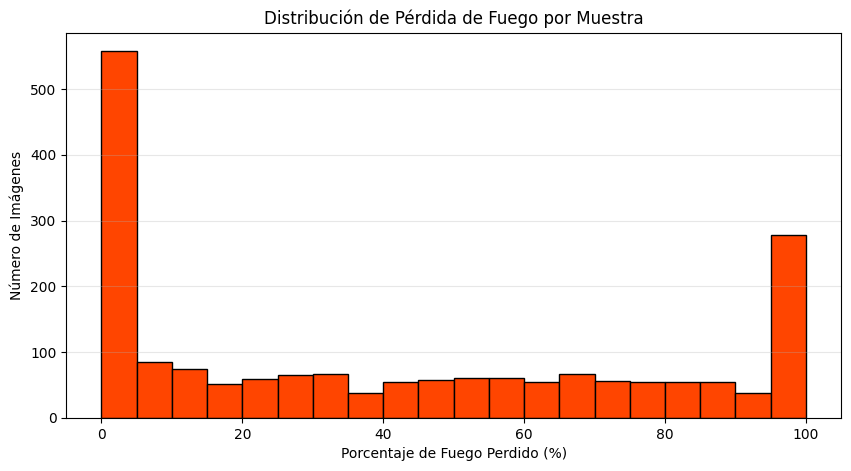

In [53]:
import matplotlib.pyplot as plt

def analyze_fire_loss_by_center_crop(dataset_instance, crop_size=256):
    """
    Escanea las imágenes originales antes del recorte para calcular cuántos 
    píxeles de fuego quedan fuera del área central.
    """
    total_fire_pixels_full = 0
    total_fire_pixels_crop = 0
    loss_per_sample = []
    
    # Usamos la estructura de rutas del dataset ya inicializado
    # Analizaremos la banda 7 de VIIRS_Day que es donde está tu 'fire_today'
    print(f"Analizando pérdida de fuego (Crop: {crop_size}x{crop_size})...")
    
    # Para no tardar una eternidad, analizamos las regiones registradas
    for region_idx, folders in dataset_instance.raw_paths.items():
        tiffs = folders["VIIRS_Day"]
        
        for path in tqdm(tiffs, desc=f"Región {region_idx}"):
            with rasterio.open(path) as src:
                # 1. Leer imagen completa (Banda 7)
                full_fire_mask = src.read(7)
                full_fire_mask = np.nan_to_num(full_fire_mask, nan=0.0)
                fire_count_full = np.sum(full_fire_mask > 0)
                
                # 2. Calcular ventana central (igual que en tu clase)
                y0 = (src.height - crop_size) // 2
                x0 = (src.width - crop_size) // 2
                win = rasterio.windows.Window(x0, y0, crop_size, crop_size)
                
                # 3. Leer solo el crop
                crop_fire_mask = src.read(7, window=win)
                crop_fire_mask = np.nan_to_num(crop_fire_mask, nan=0.0)
                fire_count_crop = np.sum(crop_fire_mask > 0)
                
                # 4. Acumular
                total_fire_pixels_full += fire_count_full
                total_fire_pixels_crop += fire_count_crop
                
                if fire_count_full > 0:
                    loss_pct = 100 * (1 - (fire_count_crop / fire_count_full))
                    loss_per_sample.append(loss_pct)

    # --- RESULTADOS ---
    pixels_lost = total_fire_pixels_full - total_fire_pixels_crop
    total_loss_pct = 100 * (pixels_lost / total_fire_pixels_full) if total_fire_pixels_full > 0 else 0
    
    print("\n" + "="*40)
    print(f"REPORTE DE PÉRDIDA POR CROP CENTRAL")
    print("-" * 40)
    print(f"Píxeles de fuego totales (Full): {total_fire_pixels_full}")
    print(f"Píxeles de fuego capturados (Crop): {total_fire_pixels_crop}")
    print(f"Píxeles perdidos: {pixels_lost}")
    print(f"PORCENTAJE DE PÉRDIDA TOTAL: {total_loss_pct:.2f}%")
    print("="*40)

    # --- GRÁFICA ---
    if loss_per_sample:
        plt.figure(figsize=(10, 5))
        plt.hist(loss_per_sample, bins=20, color='orangered', edgecolor='black')
        plt.title("Distribución de Pérdida de Fuego por Muestra")
        plt.xlabel("Porcentaje de Fuego Perdido (%)")
        plt.ylabel("Número de Imágenes")
        plt.grid(axis='y', alpha=0.3)
        plt.show()

    return total_loss_pct

# Ejemplo de uso:
loss = analyze_fire_loss_by_center_crop(train_dataset, crop_size=256)

--- Analizando balance de: Train Set ---


100%|██████████| 1788/1788 [03:45<00:00,  7.93it/s]



Resultados para Train Set:
  - Total de muestras: 1788
  - Muestras que contienen AL MENOS 1 píxel de fuego: 1439 (80.48%)
  - Píxeles totales analizados: 117,178,368
  - Píxeles de fuego: 575,010
  - Píxeles de fondo: 116,603,358
  - RATIO DE FUEGO (Pixel-wise): 0.4907%
  [!] AVISO: Desbalance crítico. Se recomienda usar pesos en la Loss Function (Pos Weight).


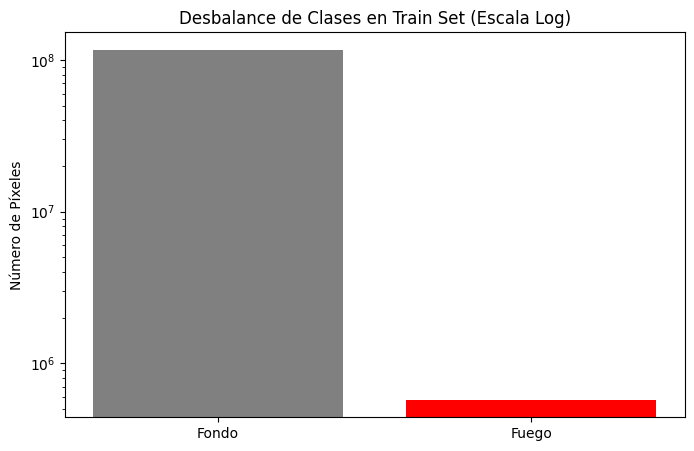

--- Analizando balance de: Validation Set ---


100%|██████████| 284/284 [00:33<00:00,  8.42it/s]



Resultados para Validation Set:
  - Total de muestras: 284
  - Muestras que contienen AL MENOS 1 píxel de fuego: 231 (81.34%)
  - Píxeles totales analizados: 18,612,224
  - Píxeles de fuego: 80,128
  - Píxeles de fondo: 18,532,096
  - RATIO DE FUEGO (Pixel-wise): 0.4305%
  [!] AVISO: Desbalance crítico. Se recomienda usar pesos en la Loss Function (Pos Weight).


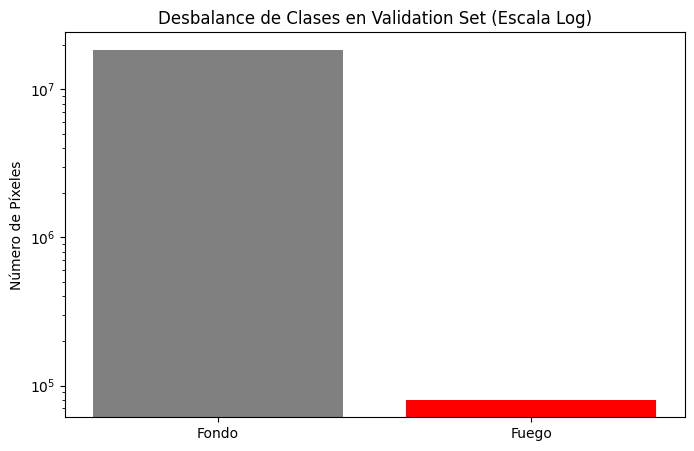

In [54]:
def analyze_dataset_balance(py_dataset, name="Dataset"):
    """
    Analiza la proporción de píxeles de fuego vs fondo en las etiquetas (Y)
    de un dataset ya procesado.
    """
    total_pixels = 0
    total_fire_pixels = 0
    samples_with_fire = 0
    
    print(f"--- Analizando balance de: {name} ---")
    
    for i in tqdm(range(len(py_dataset))):
        # Obtenemos y del dataset (ya está en formato TF: [H, W, 1])
        _, y = py_dataset[i]
        
        # Conteo de píxeles
        fire_in_sample = np.sum(y > 0)
        total_pixels += y.size
        total_fire_pixels += fire_in_sample
        
        if fire_in_sample > 0:
            samples_with_fire += 1

    # Cálculos estadísticos
    background_pixels = total_pixels - total_fire_pixels
    fire_ratio = (total_fire_pixels / total_pixels) * 100
    samples_with_fire_pct = (samples_with_fire / len(py_dataset)) * 100

    print(f"\nResultados para {name}:")
    print(f"  - Total de muestras: {len(py_dataset)}")
    print(f"  - Muestras que contienen AL MENOS 1 píxel de fuego: {samples_with_fire} ({samples_with_fire_pct:.2f}%)")
    print(f"  - Píxeles totales analizados: {total_pixels:,}")
    print(f"  - Píxeles de fuego: {total_fire_pixels:,}")
    print(f"  - Píxeles de fondo: {background_pixels:,}")
    print(f"  - RATIO DE FUEGO (Pixel-wise): {fire_ratio:.4f}%")
    
    if fire_ratio < 1.0:
        print("  AVISO: Desbalance crítico. Se recomienda usar pesos en la Loss Function (Pos Weight).")
    
    # Visualización rápida
    plt.figure(figsize=(8, 5))
    plt.bar(['Fondo', 'Fuego'], [background_pixels, total_fire_pixels], color=['gray', 'red'])
    plt.yscale('log') 
    plt.title(f"Desbalance de Clases en {name} (Escala Log)")
    plt.ylabel("Número de Píxeles")
    plt.show()

# Ejecutar el análisis
analyze_dataset_balance(train_dataset, name="Train Set")
analyze_dataset_balance(val_dataset, name="Validation Set")

# model 

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

import tensorflow.keras.backend as K
class ConvLSTMAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, channels, reduction=4, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction

        # Channel attention
        self.avg_pool = tf.keras.layers.TimeDistributed(
            tf.keras.layers.GlobalAveragePooling2D()
        )
        self.fc1 = tf.keras.layers.Dense(channels // reduction, activation='relu')
        self.fc2 = tf.keras.layers.Dense(channels, activation='sigmoid')

        # Spatial attention
        self.spatial_conv = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv2D(
                filters=1,
                kernel_size=7,
                padding='same',
                activation='sigmoid'
            )
        )

    def call(self, x):
        # x: (B, T, H, W, C)

        #  Channel Attention 
        c = self.avg_pool(x)              # (B, T, C)
        c = self.fc1(c)                   # (B, T, C//r)
        c = self.fc2(c)                   # (B, T, C)
        c = tf.expand_dims(c, axis=2)     # (B, T, 1, C)
        c = tf.expand_dims(c, axis=2)     # (B, T, 1, 1, C)

        x = x * c

        #  Spatial Attention 
        avg_s = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_s = tf.reduce_max(x, axis=-1, keepdims=True)
        s = tf.concat([avg_s, max_s], axis=-1)

        s = self.spatial_conv(s)          # (B, T, H, W, 1)

        return x * s


        return x * s
def build_convlstm_bottleneck128(
    input_shape=(3, 256, 256, 28),
    dropout=0.3
):
    inputs = layers.Input(shape=input_shape)

    #  ENCODER 
    e1 = layers.ConvLSTM2D(
        24, 3, padding='same',
        return_sequences=True,
        dropout=dropout,
        recurrent_dropout=0.1
    )(inputs)
    e1 = layers.LayerNormalization()(e1)

    p1 = layers.TimeDistributed(layers.MaxPooling2D(2))(e1)

    e2 = layers.ConvLSTM2D(
        48, 3, padding='same',
        return_sequences=True,
        dropout=dropout
    )(p1)
    e2 = layers.LayerNormalization()(e2)

    p2 = layers.TimeDistributed(layers.MaxPooling2D(2))(e2)

    e3 = layers.ConvLSTM2D(
        96, 3, padding='same',
        return_sequences=True,
        dropout=dropout
    )(p2)
    e3 = layers.LayerNormalization()(e3)

    #  BOTTLENECK 
    p3 = layers.TimeDistributed(layers.MaxPooling2D(2))(e3)

    b = layers.ConvLSTM2D(
        128, 3, padding='same',
        return_sequences=True,
        dropout=dropout
    )(p3)
    b = layers.LayerNormalization()(b)
    b = ConvLSTMAttentionBlock(128)(b)

    #  DECODER 
    u3 = layers.TimeDistributed(layers.UpSampling2D(2))(b)
    u3 = layers.Concatenate(axis=-1)([u3, e3])
    u3 = layers.ConvLSTM2D(96, 3, padding='same', return_sequences=True)(u3)

    u2 = layers.TimeDistributed(layers.UpSampling2D(2))(u3)
    u2 = layers.Concatenate(axis=-1)([u2, e2])
    u2 = layers.ConvLSTM2D(48, 3, padding='same', return_sequences=True)(u2)
    u2 = ConvLSTMAttentionBlock(48)(u2)

    u1 = layers.TimeDistributed(layers.UpSampling2D(2))(u2)
    u1 = layers.Concatenate(axis=-1)([u1, e1])
    u1 = layers.ConvLSTM2D(24, 3, padding='same', return_sequences=True)(u1)
    u1 = ConvLSTMAttentionBlock(24)(u1)

    # OUTPUT 
    x = layers.ConvLSTM2D(
        16, 3, padding='same',
        return_sequences=False
    )(u1)

    out = layers.Conv2D(1, 1, padding='same')(x)
    out = layers.Activation('linear', dtype='float32', name='predictions')(out)

    return models.Model(inputs, out, name="ConvLSTM_UNet_Att128")


In [45]:
build_convlstm_bottleneck128().summary()

Model: "ConvLSTM_UNet_Att128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 3, 256,    │          0 │ -                 │
│ (InputLayer)        │ 256, 28)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_40      │ (None, 3, 256,    │     45,024 │ input_layer_5[0]… │
│ (ConvLSTM2D)        │ 256, 24)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 256,    │         48 │ conv_lstm2d_40[0… │
│ (LayerNormalizatio… │ 256, 24)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_60 │ (None, 3, 128,    │          0 │ layer_normalizat… │
│ (TimeDistributed)   │ 128, 24)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_41      │ (None, 3, 128,    │    124,608 │ time_distributed… │
│ (ConvLSTM2D)        │ 128, 48)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 128,    │         96 │ conv_lstm2d_41[0… │
│ (LayerNormalizatio… │ 128, 48)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_61 │ (None, 3, 64, 64, │          0 │ layer_normalizat… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_42      │ (None, 3, 64, 64, │    498,048 │ time_distributed… │
│ (ConvLSTM2D)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 64, 64, │        192 │ conv_lstm2d_42[0… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_62 │ (None, 3, 32, 32, │          0 │ layer_normalizat… │
│ (TimeDistributed)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_43      │ (None, 3, 32, 32, │  1,032,704 │ time_distributed… │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 32, 32, │        256 │ conv_lstm2d_43[0… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm_attentio… │ (None, 3, 32, 32, │      8,451 │ layer_normalizat… │
│ (ConvLSTMAttention… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_65 │ (None, 3, 64, 64, │          0 │ conv_lstm_attent… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 3, 64, 64, │          0 │ time_distributed… │
│ (Concatenate)       │ 224)              │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_44      │ (None, 3, 64, 64, │  1,106,304 │ concatenate_15[0… │
│ (ConvLSTM2D)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_66 │ (None, 3, 128,    │          0 │ conv_lstm2d_44[0

 Total params: 3,255,588 (12.42 MB)

 Trainable params: 3,255,588 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
class FocalDiceLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, smooth=1.0, name="focal_dice_loss"):
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha
        self.smooth = smooth

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        y_true_tol = tf.nn.max_pool2d(y_true, ksize=5, strides=1, padding='SAME')

        y_pred_prob = tf.nn.sigmoid(y_pred)
        eps = tf.keras.backend.epsilon()
        y_pred_prob = tf.clip_by_value(y_pred_prob, eps, 1.0 - eps)

   
        focal_pos = -self.alpha * tf.pow(1 - y_pred_prob, self.gamma) * tf.math.log(y_pred_prob)
        focal_neg = -(1 - self.alpha) * tf.pow(y_pred_prob, self.gamma) * tf.math.log(1 - y_pred_prob)

        focal = y_true * focal_pos + (1 - y_true_tol) * focal_neg
        focal_loss = tf.reduce_mean(focal)

        y_true_f = tf.reshape(y_true, [-1])
        y_true_tol_f = tf.reshape(y_true_tol, [-1])
        y_pred_f = tf.reshape(y_pred_prob, [-1])

        tp = tf.reduce_sum(y_true_f * y_pred_f)
        fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
        fp = tf.reduce_sum((1 - y_true_tol_f) * y_pred_f)

        dice = (2 * tp + self.smooth) / (2 * tp + fn + fp + self.smooth)
        dice_loss = 1 - dice

        return 0.5 * focal_loss + 1.5 * dice_loss


In [55]:
"""import tensorflow as tf
import os
import json

from tensorflow.keras import mixed_precision


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.init_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f'[*] Funcionando en TPU: {tpu.master()}')

    policy = mixed_precision.Policy('mixed_bfloat16')
    mixed_precision.set_global_policy(policy)
except ValueError:
    print("[!] TPU no encontrada, usando estrategia por defecto (CPU/GPU)")
    strategy = tf.distribute.get_strategy()

print('Compute dtype: ', policy.compute_dtype)

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.history_dict = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = float(self.model.optimizer.learning_rate.numpy())
        
        current_logs = {
            "epoch": epoch + 1,
            "lr": lr,
            **{k: float(v) for k, v in logs.items()} 
        }
        self.history_dict.append(current_logs)
        
        with open(self.filepath, 'w') as f:
            json.dump(self.history_dict, f, indent=4)


def main():
    batch_size = 32 
    epochs = 50
    
    last_checkpoint_path = 'last_model_tpu.weights.h5' 
    best_checkpoint_path = 'best_fire_model_tpu.weights.h5' 
    history_path = 'training_history_tpu.json'
    
    with strategy.scope():
        model = build_unet3d(input_shape=(3, 256, 256, 28))
        
        model.compile(
            optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4, clipnorm=1.0),
            loss=BCEDiceLoss(),
            metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="iou")]
        )

    initial_epoch = 0
    best_val_iou = -1.0 
    history_cb = SaveHistoryCallback(history_path)

    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            saved_history = json.load(f)
            history_cb.history_dict = saved_history
            if saved_history:
                initial_epoch = saved_history[-1]['epoch']
                ious = [h.get('val_iou', -1.0) for h in saved_history]
                best_val_iou = max(ious)
                print(f"[*] Historial cargado. Record val_iou: {best_val_iou:.4f}")

    if os.path.exists(last_checkpoint_path):
        print(f"[*] Cargando pesos en TPU...")
        model.load_weights(last_checkpoint_path)

    best_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_checkpoint_path,
        monitor='val_iou',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
    if best_val_iou != -1.0:
        best_ckpt_callback.best = best_val_iou

    callbacks = [
        best_ckpt_callback,
        tf.keras.callbacks.ModelCheckpoint(
            filepath=last_checkpoint_path,
            save_best_only=False, 
            save_weights_only=True,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger('training_log_tpu.csv', append=True), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        history_cb
    ]

    
    print(f"\n[*] Iniciando TPU Fit en Época {initial_epoch + 1}")
    model.fit(
        train_tf_ds, 
        epochs=epochs,
        initial_epoch=initial_epoch, 
        callbacks=callbacks
    )"""

'import tensorflow as tf\nimport os\nimport json\n\nfrom tensorflow.keras import mixed_precision\n\n\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.init_tpu_system(tpu)\n    strategy = tf.distribute.TPUStrategy(tpu)\n    print(f\'[*] Funcionando en TPU: {tpu.master()}\')\n\n    policy = mixed_precision.Policy(\'mixed_bfloat16\')\n    mixed_precision.set_global_policy(policy)\nexcept ValueError:\n    print("[!] TPU no encontrada, usando estrategia por defecto (CPU/GPU)")\n    strategy = tf.distribute.get_strategy()\n\nprint(\'Compute dtype: \', policy.compute_dtype)\n\nclass SaveHistoryCallback(tf.keras.callbacks.Callback):\n    def __init__(self, filepath):\n        super().__init__()\n        self.filepath = filepath\n        self.history_dict = []\n\n    def on_epoch_end(self, epoch, logs=None):\n        logs = logs or {}\n        lr = float(self.model.optimizer.learning_rate.numpy())\n        \n       

In [56]:
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: ',policy.compute_dtype)
print('Variable dtype: ',policy.variable_dtype)

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.history_dict = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = float(self.model.optimizer.learning_rate.numpy())

        current_logs = {
            "epoch": epoch + 1,
            "lr": lr,
        **{k: float(v) for k, v in logs.items()}}
        self.history_dict.append(current_logs)
        
        with open(self.filepath, 'w') as f:
            json.dump(self.history_dict, f, indent=4)


class TolerantRecall(tf.keras.metrics.Metric):
    def __init__(self, tol_ksize=5, threshold=0.5, name="tolerant_recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tol_ksize = tol_ksize
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.nn.sigmoid(y_pred)
        y_pred_bin = tf.cast(y_pred > self.threshold, tf.float32)

        tp = tf.reduce_sum(y_pred_bin * y_true)
        y_pred_tol = tf.nn.max_pool2d(y_pred_bin, ksize=self.tol_ksize, strides=1, padding='SAME')
        fn = tf.reduce_sum(y_true * (1.0 - y_pred_tol))

        self.tp.assign_add(tp)
        self.fn.assign_add(fn)

    def result(self):
        return self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())

    def reset_state(self):
        self.tp.assign(0.0)
        self.fn.assign(0.0)

class TolerantFalseNegatives(tf.keras.metrics.Metric):
    def __init__(self, tol_ksize=5, threshold=0.5, name="tolerant_fn", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tol_ksize = tol_ksize
        self.threshold = threshold

        self.fn = self.add_weight(name="fn", initializer="zeros", dtype=tf.float32)
        self.pos = self.add_weight(name="pos", initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)


        y_pred_bin = tf.cast(tf.nn.sigmoid(y_pred) > self.threshold, tf.float32)

        y_pred_tol = tf.nn.max_pool2d(
            y_pred_bin,
            ksize=self.tol_ksize,
            strides=1,
            padding='SAME'
        )

        fn = tf.reduce_sum(y_true * (1.0 - y_pred_tol))
        pos = tf.reduce_sum(y_true)

        self.fn.assign_add(fn)
        self.pos.assign_add(pos)

    def result(self):
        return self.fn / (self.pos + tf.keras.backend.epsilon())

    def reset_state(self):
        self.fn.assign(0.0)
        self.pos.assign(0.0)


class VisualVerifyCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, save_dir='visual_logs'):
        super().__init__()
        self.dataset = dataset
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        # Tomar un batch de validación
        for inputs, targets in self.dataset.take(1):
            preds = self.model.predict(inputs, verbose=0)
            preds = tf.nn.sigmoid(preds).numpy()
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Frame de entrada (Canal 0 del último paso temporal)
            axes[0].imshow(inputs[0, -1, :, :, 0], cmap='viridis')
            axes[0].set_title("Input (Last Frame)")
            
            # Máscara Real
            axes[1].imshow(targets[0, :, :, 0], cmap='inferno')
            axes[1].set_title("Ground Truth")
            
            # Predicción
            axes[2].imshow(preds[0, :, :, 0], cmap='inferno')
            axes[2].set_title(f"Prediction (Epoch {epoch+1})")
            
            for ax in axes: ax.axis('off')
            
            plt.savefig(f"{self.save_dir}/epoch_{epoch+1}.png")
            plt.close()
            
class TolerantF1Score(tf.keras.metrics.Metric):
    def __init__(self, tol_ksize=5, threshold=0.5, name="tolerant_f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.tol_ksize = tol_ksize
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(tf.nn.sigmoid(y_pred) > self.threshold, tf.float32)
        
      
        y_true_tol = tf.nn.max_pool2d(y_true, ksize=self.tol_ksize, strides=1, padding='SAME')
   
        y_pred_tol = tf.nn.max_pool2d(y_pred_bin, ksize=self.tol_ksize, strides=1, padding='SAME')

        
        tp = tf.reduce_sum(y_pred_bin * y_true)
        
      
        fp = tf.reduce_sum(y_pred_bin * (1.0 - y_true_tol))
 
        fn = tf.reduce_sum(y_true * (1.0 - y_pred_tol))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        
        f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1

    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)
        

def main():
    batch_size = 8 
    epochs = 200
    os.makedirs('saved/checkpoints', exist_ok=True)

    last_checkpoint_path = 'saved/checkpoints/last_model_convlstm7.weights.h5'
    best_checkpoint_path = 'saved/checkpoints/best_fire_model7_convlstm.weights.h5'
    history_path = 'training_history7.json'
    
    # 1. Definición de Métricas (Añadimos F1 y IoU para el historial)
    metrics = [
        TolerantRecall(name="tol_recall"),
        TolerantFalseNegatives(name="tol_fn"),
        TolerantF1Score(name="f1_score"), # Métrica balanceada para el monitor
        tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="iou"), # IoU para clase fuego
        tf.keras.metrics.Precision(name="precision")
    ]


    model = build_convlstm_bottleneck128(input_shape=(3, 256, 256, 28))

    initial_epoch = 0
    best_val_f1 = -1.0 
    history_cb = SaveHistoryCallback(history_path)

    if os.path.exists(history_path):
        try:
            with open(history_path, 'r') as f:
                saved_history = json.load(f)
                history_cb.history_dict = saved_history
                if saved_history:
                    initial_epoch = saved_history[-1]['epoch']
                    # Buscamos val_f1_score que es más estable
                    f1_values = [h.get('val_f1_score', -1.0) for h in saved_history]
                    best_val_f1 = max(f1_values)
                    print(f"[*] Historial cargado. Reanudando en época {initial_epoch + 1}")
                    print(f"[*] Mejor val_f1 histórico: {best_val_f1:.4f}")
        except Exception as e:
            print(f"[!] Error cargando historial: {e}")

    if os.path.exists(last_checkpoint_path):
        print(f"[*] Cargando pesos recientes: {last_checkpoint_path}")
        model.load_weights(last_checkpoint_path)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss=FocalDiceLoss(),
        metrics=metrics
    )


    best_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_checkpoint_path,
        monitor='val_f1_score', 
        mode='max',            
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    if best_val_f1 != -1.0:
        best_ckpt_callback.best = best_val_f1

    visual_cb = VisualVerifyCallback(val_tf_ds)

    callbacks = [
        best_ckpt_callback,
        tf.keras.callbacks.ModelCheckpoint(
            filepath=last_checkpoint_path,
            save_best_only=False,
            save_weights_only=True,
            verbose=0 # No saturar la consola
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        history_cb,
        visual_cb
    ]

    print(f"\nIniciando entrenamiento: Pure ConvLSTM + Aggressive Loss")

    steps_per_epoch = len(train_dataset) // batch_size
    validation_steps = len(val_dataset) // batch_size
    
    model.fit(
        train_tf_ds,
        steps_per_epoch=steps_per_epoch,     
        validation_data=val_tf_ds,
        validation_steps=validation_steps,   
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=callbacks
    )

Compute dtype:  float16
Variable dtype:  float32


In [ ]:
main()


[*] Historial cargado. Reanudando en época 36
[*] Mejor val_f1 histórico: 0.6090
[*] Cargando pesos recientes: saved/checkpoints/last_model_convlstm7.weights.h5

Iniciando entrenamiento: Pure ConvLSTM + Aggressive Loss
Epoch 36/200
148/223 ━━━━━━━━━━━━━━━━━━━━ 1:01 814ms/step - f1_score: 0.7264 - iou: 0.3593 - loss: 0.1692 - precision: 0.4647 - tol_fn: 0.2789 - tol_recall: 0.6887

# eval

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_json('/kaggle/working/training_history7.json')

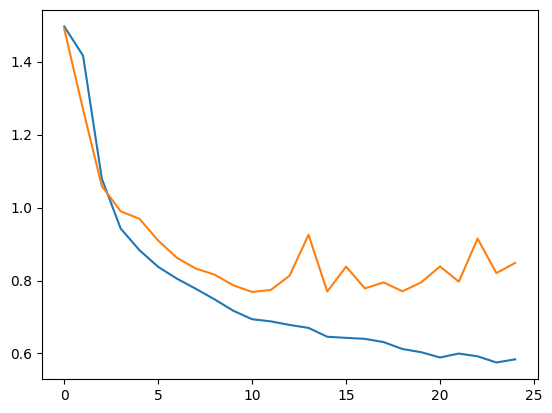

In [4]:
plt.plot(df['loss'][:25])
plt.plot(df['val_loss'][:25])
plt.savefig('fig7')

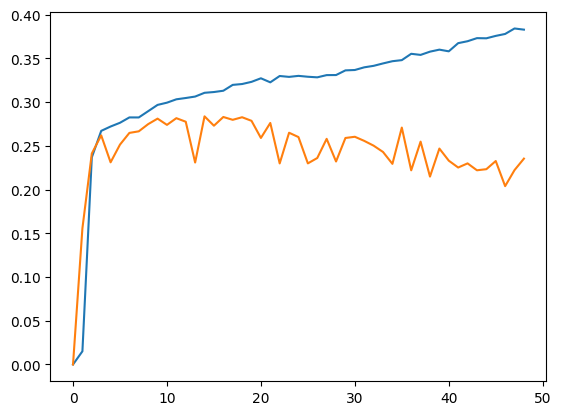

In [33]:
plt.plot(df['iou'])
plt.plot(df['val_iou'])

In [34]:
test

['/kaggle/input/ts-satfire/ts-satfire/24332763',
 '/kaggle/input/ts-satfire/ts-satfire/US_2021_NM3340210587120210426',
 '/kaggle/input/ts-satfire/ts-satfire/20700973',
 '/kaggle/input/ts-satfire/ts-satfire/24333039',
 '/kaggle/input/ts-satfire/ts-satfire/24333033',
 '/kaggle/input/ts-satfire/ts-satfire/21038333',
 '/kaggle/input/ts-satfire/ts-satfire/24462263',
 '/kaggle/input/ts-satfire/ts-satfire/24191418',
 '/kaggle/input/ts-satfire/ts-satfire/24104631',
 '/kaggle/input/ts-satfire/ts-satfire/US_2021_AZ3368910927620210616',
 '/kaggle/input/ts-satfire/ts-satfire/20900124',
 '/kaggle/input/ts-satfire/ts-satfire/20701026',
 '/kaggle/input/ts-satfire/ts-satfire/20777459',
 '/kaggle/input/ts-satfire/ts-satfire/24103571',
 '/kaggle/input/ts-satfire/ts-satfire/20562846']

In [35]:
import torch
import numpy as np
import rasterio
from rasterio.enums import Resampling
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score

class InferenceTS(TSDatasetFlat):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.target_size = 512
        self.patch_size = 256

    def _read_and_rescale(self, dataset, bands, window=None, is_label=False):
        """
        Lee y reescala una imagen a 512x512 independientemente de su tamaño original.
        """
        resampling_mode = Resampling.nearest if is_label else Resampling.bilinear
        
        # Leemos los datos reescalando directamente en la lectura de rasterio
        data = dataset.read(
            bands,
            out_shape=(len(bands) if bands else dataset.count, self.target_size, self.target_size),
            resampling=resampling_mode
        )
        return self._normalize(data, is_label=is_label)

    def __getitem__(self, idx):
        info = self.samples[idx]
        region = self.raw_paths[info["region"]]
        t_start = info["t_start"]

        # 1. Cargar y reescalar toda la secuencia a 512x512
        full_seq_512 = [] # Lista de arrays de [C, 512, 512]
        
        for t in range(t_start, t_start + self.seq_len):
            # VIIRS Day (Canales 1-6 y canal 7 por separado)
            with rasterio.open(region["VIIRS_Day"][t]) as dsrc:
                day = self._read_and_rescale(dsrc, [1, 2, 3, 4, 5, 6])
                fire_today = self._read_and_rescale(dsrc, [7], is_label=True)

            # VIIRS Night
            with rasterio.open(region["VIIRS_Night"][t]) as nsrc:
                # Asumiendo que queremos los últimos 2 canales según tu código original
                num_bands = nsrc.count
                night = self._read_and_rescale(nsrc, [num_bands-1, num_bands])

            # FirePred
            with rasterio.open(region["FirePred"][t]) as fsrc:
                firep = self._read_and_rescale(fsrc, None)

            # Combinar todos los canales para el tiempo T: [C_total, 512, 512]
            combined_t = np.concatenate([day, fire_today, night, firep], axis=0)
            full_seq_512.append(combined_t)

        # Convertir a tensor: [T, C, 512, 512]
        full_seq_tensor = np.stack(full_seq_512)

        # 2. Dividir en 4 parches de 256x256
        patches = []
        # Cuadrantes: Top-Left, Top-Right, Bottom-Left, Bottom-Right
        offsets = [(0, 0), (0, 256), (256, 0), (256, 256)]
        
        for (y, x) in offsets:
            patch = full_seq_tensor[:, :, y:y+256, x:x+256]
            patches.append(torch.from_numpy(patch).float())

        return {
            "patches": torch.stack(patches), # [4, T, C, 256, 256]
            "sample_id": info['sample_id']
        }

    def reconstruct_image(self, model, patches_tensor, device="cuda"):
        """
        Toma el tensor de 4 parches, corre el modelo y une los resultados.
        """
        model.eval()
        model.to(device)
        preds = []
        
        with torch.no_grad():
            # patches_tensor: [4, T, C, 256, 256]
            for i in range(4):
                input_patch = patches_tensor[i].unsqueeze(0).to(device)
                output = model(input_patch) # Salida esperada: [1, 1, 256, 256]
                preds.append(output.squeeze().cpu().numpy())

        # Unir patches
        top = np.concatenate([preds[0], preds[1]], axis=1)
        bottom = np.concatenate([preds[2], preds[3]], axis=1)
        full_reconstruction = np.concatenate([top, bottom], axis=0)
        
        return full_reconstruction # [512, 512]




import tensorflow as tf

class InferenceTF(InferenceTS):
    def predict_full_image(self, model, patches_tensor):
        """
        Predice los 4 parches y los une. 
        Mantiene compatibilidad con Mixed Precision si el modelo la usa.
        """
        patches_np = patches_tensor.numpy()
        # Transponer de PyTorch [4, T, C, H, W] a TF [4, T, H, W, C]
        patches_tf = np.transpose(patches_np, (0, 1, 3, 4, 2))
        
        preds = []
        for i in range(4):
            patch = patches_tf[i:i+1] # Shape: (1, T, 256, 256, C)
            
            # Predicción: salida (1, 256, 256, 1)
            p = model.predict(patch, verbose=0)
            # Aplicar sigmoid explícito ya que el modelo devuelve logits lineales
            p_prob = tf.nn.sigmoid(p).numpy()
            preds.append(np.squeeze(p_prob))

        # Reconstrucción 2x2 para formar la imagen de 512x512
        top = np.concatenate([preds[0], preds[1]], axis=1)
        bottom = np.concatenate([preds[2], preds[3]], axis=1)
        return np.concatenate([top, bottom], axis=0) # [512, 512]

    def get_ground_truth(self, idx):
        """Extrae el target real de 512x512 reescalado correctamente"""
        info = self.samples[idx]
        region = self.raw_paths[info["region"]]
        # El target es el tiempo inmediatamente después de la secuencia de entrada
        t_target = info["t_start"] + self.seq_len
        
        with rasterio.open(region["VIIRS_Day"][t_target]) as dsrc:
            # Canal 7 es el fuego (target). Reescalado a 512x512.
            y_true = dsrc.read(
                7, 
                out_shape=(self.target_size, self.target_size), 
                resampling=Resampling.nearest
            )
            # Normalizar para que sea 0 y 1 (bool/float32)
            return self._normalize(y_true, is_label=True)

    def evaluate_tolerantly(self, y_true, y_pred_prob, tol_ksize=5, threshold=0.5):
        """
        Calcula F1 y Recall usando la misma lógica de tolerancia que el entrenamiento.
        y_true: [512, 512]
        y_pred_prob: [512, 512] (probabilidades 0-1)
        """
        # Convertir a tensores de 4D para pooling [Batch, H, W, Channels]
        y_true_t = tf.cast(y_true[np.newaxis, ..., np.newaxis], tf.float32)
        y_pred_t = tf.cast(y_pred_prob[np.newaxis, ..., np.newaxis], tf.float32)
        
        # Binarizar predicción
        y_pred_bin = tf.cast(y_pred_t > threshold, tf.float32)

        # Crear máscara de tolerancia (dilatación del Ground Truth)
        y_true_tol = tf.nn.max_pool2d(
            y_true_t, ksize=tol_ksize, strides=1, padding='SAME'
        )

        # --- Métricas Tolerantes ---
        # True Positives: Predicción correcta dentro de zona tolerante
        tp = tf.reduce_sum(y_pred_bin * y_true_tol)
        
        # False Positives: Fuera de la zona de tolerancia
        fp = tf.reduce_sum(y_pred_bin * (1.0 - y_true_tol))
        
        # False Negatives: Fuego real no cubierto por predicción (usando pooling en pred para ser laxos)
        y_pred_tol = tf.nn.max_pool2d(y_pred_bin, ksize=tol_ksize, strides=1, padding='SAME')
        fn = tf.reduce_sum(y_true_t * (1.0 - y_pred_tol))

        # Cálculos finales
        precision = tp / (tp + fp + 1e-7)
        recall = tp / (tp + fn + 1e-7)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

        return {
            "f1_tolerant": f1.numpy(),
            "recall_tolerant": recall.numpy(),
            "precision_tolerant": precision.numpy()
        }

In [ ]:
!ls saved/checkpoints


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import scipy.ndimage as ndimage
from sklearn.metrics import jaccard_score, confusion_matrix, ConfusionMatrixDisplay

def get_tolerant_labels(y_true, pixels=2):
    """Dilata las etiquetas reales para permitir un margen de error."""
    struct = ndimage.generate_binary_structure(2, 1)
    struct = ndimage.iterate_structure(struct, pixels)
    return ndimage.binary_dilation(y_true, structure=struct).astype(np.uint8)

# 1. Configuración de Modelo y Pesos
input_shape = (3, 256, 256, 28)
model = build_convlstm_bottleneck128(input_shape=input_shape)
weights_path = "saved/checkpoints/best_fire_model7_convlstm.weights.h5"

if Path(weights_path).exists():
    model.load_weights(weights_path)
    print(f"[*] Pesos cargados: {weights_path}")
else:
    print("[!] Error: No se encontraron los pesos.")

# 2. Dataset de Inferencia
ds_inference = InferenceTF(path_valid=test, cache_dir=cache_base/'test')

stats = []
g_tp_tol, g_fp_tol, g_fn_tol = 0, 0, 0
output_vis_dir = Path("inference_results")
output_vis_dir.mkdir(exist_ok=True)

print(f"Iniciando inferencia y visualización...")

# 3. Bucle de Inferencia con Visualización
for i in tqdm(range(len(ds_inference))):
    sample = ds_inference[i]
    patches = sample["patches"]
    sample_id = sample["sample_id"]
    
    # Predicción y GT (512x512)
    pred_probs = ds_inference.predict_full_image(model, patches)
    y_true_512 = ds_inference.get_ground_truth(i)
    
    y_true_bin = (y_true_512 > 0.5).astype(np.uint8)
    y_pred_bin = (pred_probs > 0.5).astype(np.uint8)
    
    # Lógica de Tolerancia para métricas
    y_true_tol = get_tolerant_labels(y_true_bin, pixels=2)
    
    # Cálculo de métricas locales
    tp_t = np.sum((y_pred_bin == 1) & (y_true_tol == 1))
    fp_t = np.sum((y_pred_bin == 1) & (y_true_tol == 0))
    fn_t = np.sum((y_pred_bin == 0) & (y_true_bin == 1))
    
    p_tol = tp_t / (tp_t + fp_t + 1e-7)
    r_tol = tp_t / (tp_t + fn_t + 1e-7)
    f1_t = 2 * (p_tol * r_tol) / (p_tol + r_tol + 1e-7)
    
    # Acumular globales
    g_tp_tol += tp_t; g_fp_tol += fp_t; g_fn_tol += fn_t
    stats.append({"id": sample_id, "f1_tol": f1_t})

    # --- BLOQUE DE VISUALIZACIÓN ---
    # Solo visualizamos si hay fuego en el target o en la predicción (para no ver imágenes vacías)
    if np.sum(y_true_bin) > 0 or np.sum(y_pred_bin) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Columna 1: Ground Truth
        axes[0].imshow(y_true_bin, cmap='inferno')
        axes[0].set_title(f"Target Real (GT)\nID: {sample_id}")
        
        # Columna 2: Predicción (Probabilidades)
        im = axes[1].imshow(pred_probs, cmap='inferno')
        axes[1].set_title(f"Predicción (Probabilidades)\nF1 Tol: {f1_t:.4f}")
        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
        
        # Columna 3: Error Overlay (Donde falló)
        # Verde: TP, Rojo: FP, Azul: FN
        overlay = np.zeros((512, 512, 3))
        overlay[..., 1] = (y_pred_bin * y_true_bin) # Verde: Acierto exacto
        overlay[..., 0] = (y_pred_bin * (1 - y_true_tol)) # Rojo: Falso Positivo (lejos del fuego)
        overlay[..., 2] = (y_true_bin * (1 - y_pred_bin)) # Azul: Falso Negativo (olvido)
        
        axes[2].imshow(overlay)
        axes[2].set_title("Análisis de Error\nVerde:TP, Rojo:FP, Azul:FN")
        
        for ax in axes: ax.axis('off')
        
        plt.savefig(output_vis_dir / f"pred_{sample_id}.png", bbox_inches='tight')
        plt.close() 

# 4. Resumen Final
final_f1 = 2 * ( (g_tp_tol/(g_tp_tol+g_fp_tol)) * (g_tp_tol/(g_tp_tol+g_fn_tol)) ) / ( (g_tp_tol/(g_tp_tol+g_fp_tol)) + (g_tp_tol/(g_tp_tol+g_fn_tol)) )
print(f"\n[!] Inferencia terminada. F1 Tolerante Global: {final_f1:.4f}")
pd.DataFrame(stats).to_csv("test_metrics_detailed.csv", index=False)

[*] Pesos cargados: saved/checkpoints/best_fire_model7_convlstm.weights.h5
Generando catálogo ...


100%|██████████| 15/15 [00:00<00:00, 34952.53it/s]


Dataset listo: 227 muestras independientes.
Iniciando inferencia y visualización...


  0%|          | 0/227 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1768544819.568896     106 service.cc:152] XLA service 0x4fe728c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768544819.568929     106 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768544821.005236     106 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768544825.060040     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 227/227 [09:30<00:00,  2.51s/it]


[!] Inferencia terminada. F1 Tolerante Global: 0.6929


[*] Pesos cargados correctamente desde saved/checkpoints/best_fire_model7_convlstm.weights.h5
Cargando catálogo plano desde saved/data_cache/test/catalog_flat_s3_st1_c256.json...
Dataset listo: 227 muestras independientes.
Iniciando Inferencia Completa en 227 muestras...


100%|██████████| 227/227 [06:39<00:00,  1.76s/it]


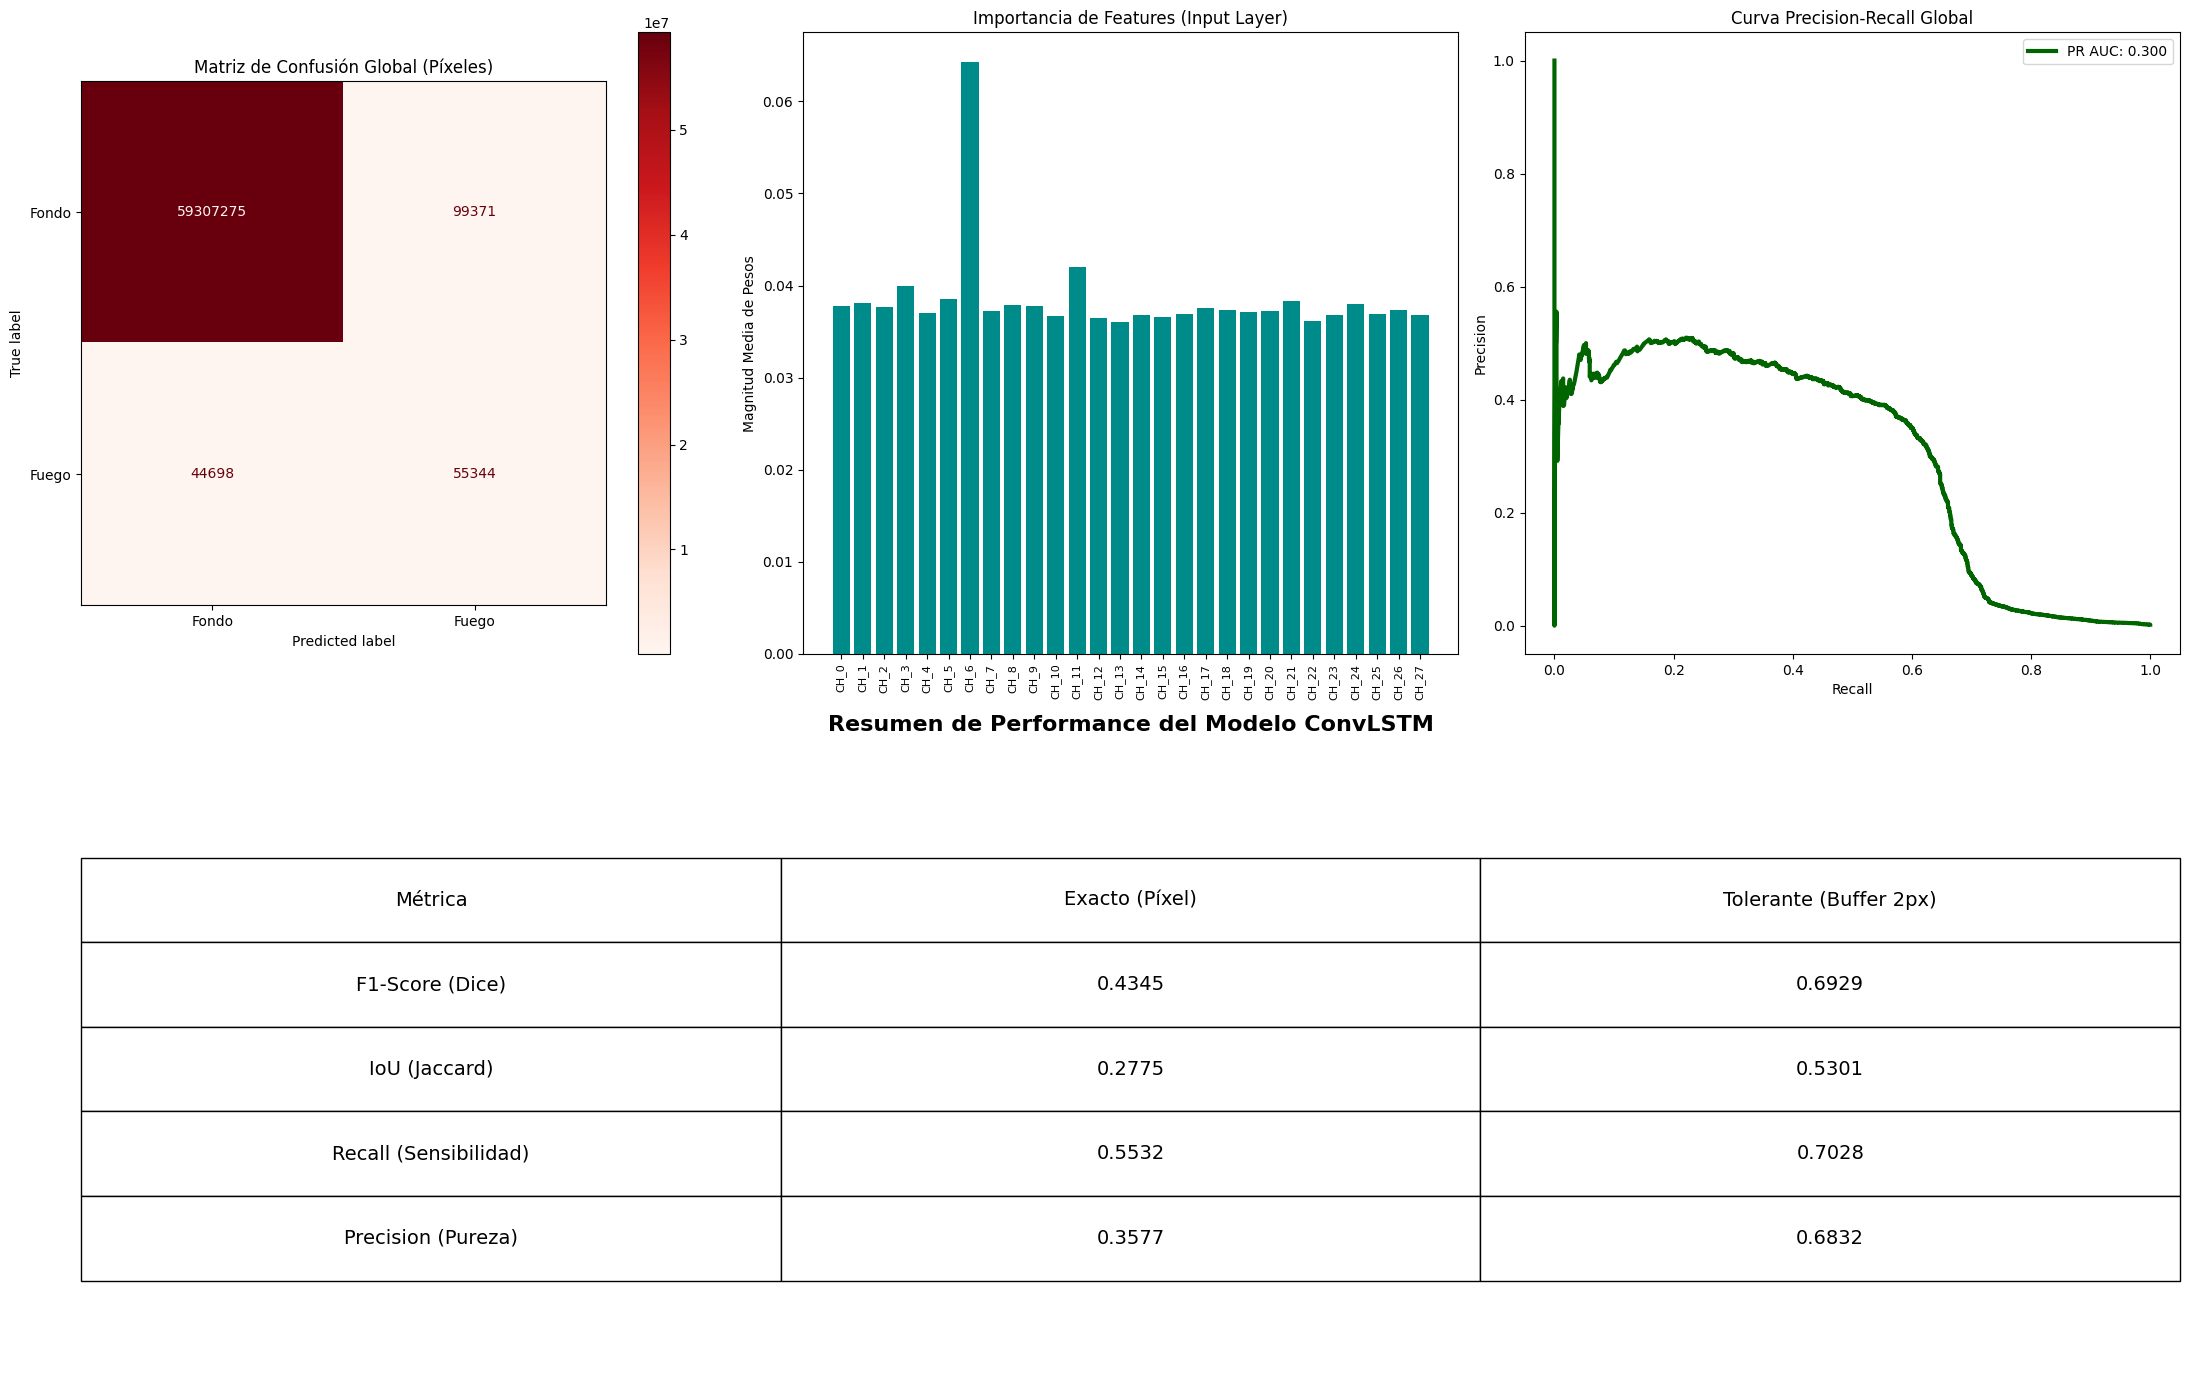

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
import scipy.ndimage as ndimage
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc


def get_tolerant_labels(y_true, pixels=2):
    """Dilata las etiquetas reales para permitir un margen de error espacial (Buffer)."""
    struct = ndimage.generate_binary_structure(2, 1)
    struct = ndimage.iterate_structure(struct, pixels)
    return ndimage.binary_dilation(y_true, structure=struct).astype(np.uint8)

def calc_metrics_group(tp, fp, fn):
    """Calcula el set estándar de métricas de segmentación."""
    prec = tp / (tp + fp + 1e-7)
    rec = tp / (tp + fn + 1e-7)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-7)
    iou = tp / (tp + fp + fn + 1e-7)
    return prec, rec, f1, iou


input_shape = (3, 256, 256, 28)
model = build_convlstm_bottleneck128(input_shape=input_shape)
weights_path = "saved/checkpoints/best_fire_model7_convlstm.weights.h5"

if Path(weights_path).exists():
    model.load_weights(weights_path)
    print(f"[*] Pesos cargados correctamente desde {weights_path}")
else:
    print("[!] Error: No se encontraron los pesos en la ruta especificada.")

ds_inference = InferenceTF(path_valid=test, cache_dir=cache_base/'test')


metrics_accum = {
    'tp_ex': 0, 'fp_ex': 0, 'fn_ex': 0, 'tn_ex': 0,
    'tp_tol': 0, 'fp_tol': 0, 'fn_tol': 0
}

all_probs = []  
all_targets = []
output_vis_dir = Path("inference_results")
output_vis_dir.mkdir(exist_ok=True)


first_layer_weights = model.layers[1].get_weights()[0]

feature_importance_global = np.mean(np.abs(first_layer_weights), axis=(0, 1, 3))

print(f"Iniciando Inferencia Completa en {len(ds_inference)} muestras...")


for i in tqdm(range(len(ds_inference))):
    sample = ds_inference[i]
    patches = sample["patches"]
    sample_id = sample["sample_id"]
    
    #  Predicción y GT
    pred_probs = ds_inference.predict_full_image(model, patches)
    y_true_512 = ds_inference.get_ground_truth(i)
    
    y_true_bin = (y_true_512 > 0).astype(np.uint8)
    y_pred_bin = (pred_probs > 0.5).astype(np.uint8)
    y_true_tol = get_tolerant_labels(y_true_bin, pixels=2)

    #  Contadores Exactos
    tp_e = np.sum((y_pred_bin == 1) & (y_true_bin == 1))
    fp_e = np.sum((y_pred_bin == 1) & (y_true_bin == 0))
    fn_e = np.sum((y_pred_bin == 0) & (y_true_bin == 1))
    tn_e = np.sum((y_pred_bin == 0) & (y_true_bin == 0))

    # Contadores Tolerantes
    tp_t = np.sum((y_pred_bin == 1) & (y_true_tol == 1))
    fp_t = np.sum((y_pred_bin == 1) & (y_true_tol == 0))
   
    fn_t = fn_e 

 
    metrics_accum['tp_ex'] += tp_e; metrics_accum['fp_ex'] += fp_e
    metrics_accum['fn_ex'] += fn_e; metrics_accum['tn_ex'] += tn_e
    metrics_accum['tp_tol'] += tp_t; metrics_accum['fp_tol'] += fp_t
    metrics_accum['fn_tol'] += fn_t

    if i % 3 == 0:
        all_probs.append(pred_probs.flatten()[::25])
        all_targets.append(y_true_bin.flatten()[::25])


    if (np.sum(y_true_bin) > 0 or np.sum(y_pred_bin) > 0) and i % 10 == 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(y_true_bin, cmap='inferno'); axes[0].set_title("GT")
        axes[1].imshow(pred_probs, cmap='inferno'); axes[1].set_title("Pred")
        err = np.zeros((512, 512, 3))
        err[..., 1] = (y_pred_bin * y_true_bin) # Verde: TP
        err[..., 0] = (y_pred_bin * (1 - y_true_tol)) # Rojo: FP
        err[..., 2] = (y_true_bin * (1 - y_pred_bin)) # Azul: FN
        axes[2].imshow(err); axes[2].set_title("Error (V:TP, R:FP, A:FN)")
        plt.savefig(output_vis_dir / f"sample_{sample_id}.png")
        plt.close()



p_ex, r_ex, f1_ex, iou_ex = calc_metrics_group(metrics_accum['tp_ex'], metrics_accum['fp_ex'], metrics_accum['fn_ex'])
p_tol, r_tol, f1_tol, iou_tol = calc_metrics_group(metrics_accum['tp_tol'], metrics_accum['fp_tol'], metrics_accum['fn_tol'])


all_targets_cat = np.concatenate(all_targets)
all_probs_cat = np.concatenate(all_probs)

fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(2, 3)


ax0 = fig.add_subplot(gs[0, 0])
cm = np.array([[metrics_accum['tn_ex'], metrics_accum['fp_ex']], 
               [metrics_accum['fn_ex'], metrics_accum['tp_ex']]])
ConfusionMatrixDisplay(cm, display_labels=['Fondo', 'Fuego']).plot(ax=ax0, cmap='Reds', values_format='d')
ax0.set_title("Matriz de Confusión Global (Píxeles)")


ax1 = fig.add_subplot(gs[0, 1])
ch_indices = np.arange(28)
ax1.bar(ch_indices, feature_importance_global, color='darkcyan')
ax1.set_xticks(ch_indices)
ax1.set_xticklabels([f"CH_{i}" for i in ch_indices], rotation=90, fontsize=8)
ax1.set_title("Importancia de Features (Input Layer)")
ax1.set_ylabel("Magnitud Media de Pesos")


ax2 = fig.add_subplot(gs[0, 2])
prec_c, rec_c, _ = precision_recall_curve(all_targets_cat, all_probs_cat)
ax2.plot(rec_c, prec_c, color='darkgreen', lw=3, label=f'PR AUC: {auc(rec_c, prec_c):.3f}')
ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
ax2.set_title("Curva Precision-Recall Global")
ax2.legend()


ax3 = fig.add_subplot(gs[1, :])
ax3.axis('off')
metric_data = [
    ["F1-Score4", f"{f1_ex:.4f}", f"{f1_tol:.4f}"],
    ["IoU ", f"{iou_ex:.4f}", f"{iou_tol:.4f}"],
    ["Recall ", f"{r_ex:.4f}", f"{r_tol:.4f}"],
    ["Precision ", f"{p_ex:.4f}", f"{p_tol:.4f}"]
]
table = ax3.table(cellText=metric_data, colLabels=["Métrica", "Exacto (Píxel)", "Tolerante "], 
                  loc='center', cellLoc='center')
table.scale(1, 4)
table.set_fontsize(14)
ax3.set_title("Resumen de Performance del Modelo ConvLSTM", pad=20, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Guardar resultados
pd.DataFrame([metrics_accum]).to_csv("pixel_counts_final.csv", index=False)